### Credit Card Approval Prediction
Data Source: https://www.kaggle.com/rikdifos/credit-card-approval-prediction

# STEP 1 - Import Libraries

"""
READ ME FIRST!

Below Python code requires some Python packages and modules that do not come with
a standard Jupyter notebook. Please install below packages in Anaconda Prompt 
before starting running the code

1. imblearn package
        Installation Code: pip install imblearn
2. lightbgm package
        Installation Code: pip install lightgbm
3. catboost package
        Installation Code: pip install catboost
4. xgboost package
        Installation Code: pip install xgboost
"""

In [1]:
## STEP 1.1 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## STEP 1.2 Import Scikit-learn libraries
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier

In [3]:
## STEP 1.3 - Import Libraries for Scaling and Spliting into training and test and Cross Validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [4]:
## STEP 1.4 - Import sklearn.ensemble Classifier libraries
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [5]:
## STEP 1.5 - Import libraries to measure "goodness"
from sklearn.metrics import accuracy_score, recall_score, average_precision_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_precision_recall_curve

In [6]:
## STEP 1.6 - Import more libraries 
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# STEP 2: Describe Datasets  

In [7]:
## STEP 2.1 - Read Data Files
applicationRecords = pd.read_csv("application_record.csv", encoding = 'utf-8') 
creditRecords = pd.read_csv("credit_record.csv", encoding = 'utf-8') 

In [8]:
## STEP 2.2 Describe Application Records Data
print("====================================")
print("Data: Application Records")
print("====================================")
print("SHAPE: ", applicationRecords.shape)
print("====================================")
print(applicationRecords.describe())
print("====================================")
print(applicationRecords.info())
print("====================================")
print(applicationRecords.head())
print("====================================")

Data: Application Records
SHAPE:  (438557, 18)
                 ID   CNT_CHILDREN  AMT_INCOME_TOTAL     DAYS_BIRTH  \
count  4.385570e+05  438557.000000      4.385570e+05  438557.000000   
mean   6.022176e+06       0.427390      1.875243e+05  -15997.904649   
std    5.716370e+05       0.724882      1.100869e+05    4185.030007   
min    5.008804e+06       0.000000      2.610000e+04  -25201.000000   
25%    5.609375e+06       0.000000      1.215000e+05  -19483.000000   
50%    6.047745e+06       0.000000      1.607805e+05  -15630.000000   
75%    6.456971e+06       1.000000      2.250000e+05  -12514.000000   
max    7.999952e+06      19.000000      6.750000e+06   -7489.000000   

       DAYS_EMPLOYED  FLAG_MOBIL  FLAG_WORK_PHONE     FLAG_PHONE  \
count  438557.000000    438557.0    438557.000000  438557.000000   
mean    60563.675328         1.0         0.206133       0.287771   
std    138767.799647         0.0         0.404527       0.452724   
min    -17531.000000         1.0         

In [9]:
## STEP 2.3 Describe Credit Records Data
print("====================================")
print("Data: Credit Records")
print("====================================")
print("SHAPE: ", creditRecords.shape)
print("====================================")
print(creditRecords.describe())
print("====================================")
print(creditRecords.info())
print("====================================")
print(creditRecords.head())
print("====================================")

Data: Credit Records
SHAPE:  (1048575, 3)
                 ID  MONTHS_BALANCE
count  1.048575e+06    1.048575e+06
mean   5.068286e+06   -1.913700e+01
std    4.615058e+04    1.402350e+01
min    5.001711e+06   -6.000000e+01
25%    5.023644e+06   -2.900000e+01
50%    5.062104e+06   -1.700000e+01
75%    5.113856e+06   -7.000000e+00
max    5.150487e+06    0.000000e+00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB
None
        ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0
2  5001711              -2      0
3  5001711              -3      0
4  5001712               0      C


# STEP 3: Merge Datasets into One

In [10]:
## STEP 3.1 - Remove more than one year's credit record 
creditRecords = creditRecords[creditRecords.MONTHS_BALANCE > -13]

In [11]:
## STEP 3.2 - Merge Application Record with earliest credit month
month=pd.DataFrame(creditRecords.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
month=month.rename(columns={'MONTHS_BALANCE':'month'}) 
appRecords=pd.merge(applicationRecords,month,how="left",on="ID") 

## Status Description
0: 1-29 days past due 
1: 30-59 days past due 
2: 60-89 days overdue 
3: 90-119 days overdue 
4: 120-149 days overdue 
5: Overdue or bad debts, write-offs for more than 150 days 
C: paid off that month 
X: No loan for the month

In [12]:
## STEP 3.3 - Label data based on status
creditRecords['hasDefaulted'] = None
creditRecords['hasDefaulted'][creditRecords['STATUS'] =='1']='Yes'
creditRecords['hasDefaulted'][creditRecords['STATUS'] =='2']='Yes' 
creditRecords['hasDefaulted'][creditRecords['STATUS'] =='3']='Yes' 
creditRecords['hasDefaulted'][creditRecords['STATUS'] =='4']='Yes' 
creditRecords['hasDefaulted'][creditRecords['STATUS'] =='5']='Yes'

<ipython-input-12-5cc5d5b8515f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  creditRecords['hasDefaulted'][creditRecords['STATUS'] =='1']='Yes'
<ipython-input-12-5cc5d5b8515f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  creditRecords['hasDefaulted'][creditRecords['STATUS'] =='2']='Yes'
<ipython-input-12-5cc5d5b8515f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  creditRecords['hasDefaulted'][creditRecords['STATUS'] =='3']='

In [13]:
## STEP 3.4 - Label data based on hasDefaulted and merge with appRecords
customerCredit=creditRecords.groupby('ID').count()
customerCredit['hasDefaulted'][customerCredit['hasDefaulted'] > 0]='Yes' 
customerCredit['hasDefaulted'][customerCredit['hasDefaulted'] == 0]='No' 
customerCredit = customerCredit[['hasDefaulted']]
appRecords=pd.merge(appRecords,customerCredit,how='inner',on='ID')
appRecords['risky']=appRecords['hasDefaulted']
appRecords.loc[appRecords['risky']=='Yes','risky']=1
appRecords.loc[appRecords['risky']=='No','risky']=0

In [14]:
## STEP 3.5 - Drop missing data
appRecords.dropna()
appRecords = appRecords.mask(appRecords == 'NULL').dropna()

In [15]:
## STEP 3.6 Describe Application Records Data
print("====================================")
print("Data: Application Records")
print("====================================")
print("SHAPE: ", appRecords.shape)

Data: Application Records
SHAPE:  (20596, 21)


# STEP 4 : Define Utility Functions

In [16]:
## STEP 4.1 Define function to covert to dummy and drop highest count 
def addDummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [17]:
## STEP 4.2 Define function to group variables
def groupFeature(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [18]:
# STEP 4.3 define function for model metrics comparison
def modelMetrics(classifier, name, X_test, y_test):
    """
    We want to see how the different models react to the same 
    dataset. We should capture multiple metrics for each model.
    
    classifier: the classifier we are capturing metrics for
    
    name: a name to identify the classifier
    
    X_test: the X array for the test set
    
    y_test: the output variable (actual) for test set
    """
    retVal = {}
    
    metrics = {}
    predictions = classifier.predict(X_test)
    metrics["a_score"] = accuracy_score(y_test, predictions)
    metrics["r_score"] = recall_score(y_test, predictions)
    metrics["p_score"] = precision_score(y_test, predictions)
    metrics["f1_score"] = f1_score(y_test, predictions)
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    totDefaulters = y_test.sum()
    totNonDefaulters = len(y_test) - totDefaulters
    
    # Error rate non-defaulters = false positives / total non-defaulters
    metrics["errorNondefaulters"] = fp/totNonDefaulters
    # Accuracy for non-defaulters = true negatives / total non-defaulters
    metrics["accNondefaulters"] = tn/totNonDefaulters
    # Error rate for defaulters = false negatives / total defaulters
    metrics["errorDefaulters"] = fn/totDefaulters
    # Accuracy for defaulters = true positives / total defaulters
    metrics["accDefaulters"] = tp/totDefaulters
    # ROC AUC score
    metrics["roc_auc_score"] = roc_auc_score(y_test,
                                             classifier.predict_proba(X_test)[:,1])
    # Average precision score
    metrics["avg_p_score"] = average_precision_score(y_test,
                                                     classifier.predict_proba(X_test)[:,1])
    metrics["truePositive"] = tp
    metrics["trueNegative"] = tn
    metrics["falsePositive"] = fp
    metrics["falseNegative"] = fn
    retVal[name] = metrics
    
    return retVal

# STEP 5: Format Features into Dummy Variables

In [19]:
## STEP 5.01 Format CODE_GENDER feature
appRecords['CODE_GENDER'] = appRecords['CODE_GENDER'].replace(['F','M'],[0,1])
print(appRecords['CODE_GENDER'].value_counts())

0    12727
1     7869
Name: CODE_GENDER, dtype: int64


In [20]:
## STEP 5.02 Format FLAG_OWN_CAR feature
appRecords['FLAG_OWN_CAR'] = appRecords['FLAG_OWN_CAR'].replace(['N','Y'],[0,1])
print(appRecords['FLAG_OWN_CAR'].value_counts())

0    11936
1     8660
Name: FLAG_OWN_CAR, dtype: int64


In [21]:
## STEP 5.03 Format FLAG_OWN_REALTY feature
appRecords['FLAG_OWN_REALTY'] = appRecords['FLAG_OWN_REALTY'].replace(['N','Y'],[0,1])
print(appRecords['FLAG_OWN_REALTY'].value_counts())

1    13340
0     7256
Name: FLAG_OWN_REALTY, dtype: int64


In [22]:
## STEP 5.04 Format FLAG_PHONE feature
appRecords['FLAG_PHONE']=appRecords['FLAG_PHONE'].astype(str)
appRecords.drop(appRecords[appRecords['FLAG_PHONE'] == 'nan' ].index, inplace=True)
print(appRecords['FLAG_PHONE'].value_counts())

0    14568
1     6028
Name: FLAG_PHONE, dtype: int64


In [23]:
## STEP 5.05 Format FLAG_EMAIL feature
appRecords['FLAG_EMAIL']=appRecords['FLAG_EMAIL'].astype(str)
print(appRecords['FLAG_EMAIL'].value_counts())

0    18492
1     2104
Name: FLAG_EMAIL, dtype: int64


In [24]:
## STEP 5.06 Format FLAG_WORK_PHONE feature
appRecords['FLAG_WORK_PHONE']=appRecords['FLAG_WORK_PHONE'].astype(str)
appRecords.drop(appRecords[appRecords['FLAG_WORK_PHONE'] == 'nan' ].index, inplace=True)
appRecords['FLAG_WORK_PHONE']= pd.to_numeric(appRecords['FLAG_WORK_PHONE'])
print(appRecords['FLAG_WORK_PHONE'].value_counts())

0    14896
1     5700
Name: FLAG_WORK_PHONE, dtype: int64


In [25]:
## STEP 5.07 Format CNT_CHILDREN feature
appRecords.loc[appRecords['CNT_CHILDREN'] >= 2,'CNT_CHILDREN']='2More'
print(appRecords['CNT_CHILDREN'].value_counts(sort=False))
appRecords = addDummy(appRecords,'CNT_CHILDREN')

0        13111
1         4965
2More     2520
Name: CNT_CHILDREN, dtype: int64


(2.544, 18.18]      11993
(18.18, 33.66]       6924
(33.66, 49.14]       1377
(49.14, 64.62]        137
(64.62, 80.1]         107
(80.1, 95.58]          41
(95.58, 111.06]         3
(111.06, 126.54]        3
(126.54, 142.02]        4
(142.02, 157.5]         7
Name: AMT_INCOME_TOTAL, dtype: int64


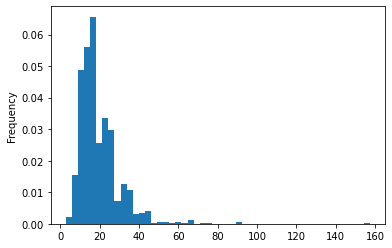

In [26]:
## STEP 5.08 Format AMT_INCOME_TOTAL feature
appRecords['AMT_INCOME_TOTAL']=appRecords['AMT_INCOME_TOTAL'].astype(object)
appRecords['AMT_INCOME_TOTAL'] = appRecords['AMT_INCOME_TOTAL']/10000 
print(appRecords['AMT_INCOME_TOTAL'].value_counts(bins=10,sort=False))
appRecords['AMT_INCOME_TOTAL'].plot(kind='hist',bins=50,density=True)
appRecords = groupFeature(appRecords,'AMT_INCOME_TOTAL', 3, ["low","medium", "high"], qcut = True)
appRecords = addDummy(appRecords,'gp_AMT_INCOME_TOTAL')

(19.951999999999998, 24.7]    0.027238
(24.7, 29.4]                  0.135172
(29.4, 34.1]                  0.168674
(34.1, 38.8]                  0.140124
(38.8, 43.5]                  0.173869
(43.5, 48.2]                  0.140755
(48.2, 52.9]                  0.097883
(52.9, 57.6]                  0.077831
(57.6, 62.3]                  0.031511
(62.3, 67.0]                  0.006943
Name: Age, dtype: float64


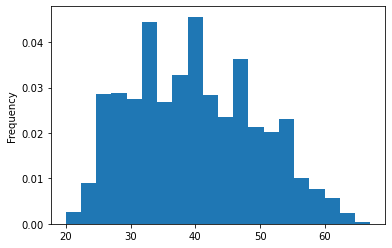

In [27]:
## STEP 5.09 Format DAYS_BIRTH feature
appRecords['Age']=-(appRecords['DAYS_BIRTH'])//365	
print(appRecords['Age'].value_counts(bins=10,normalize=True,sort=False))
appRecords['Age'].plot(kind='hist',bins=20,density=True)
appRecords = groupFeature(appRecords,'Age',5, ["lowest","low","medium","high","highest"])
appRecords = addDummy(appRecords,'gp_Age')

lowest     15027
low         4055
medium      1104
highest       77
high         333
Name: gp_yearsEmployed, dtype: int64


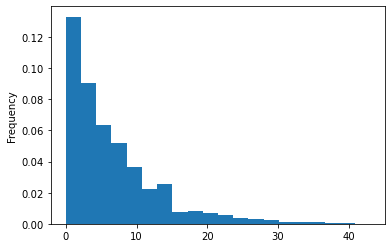

In [28]:
## STEP 5.10 Format DAYS_EMPLOYED feature
appRecords['yearsEmployed']=-(appRecords['DAYS_EMPLOYED'])//365	
appRecords[appRecords['yearsEmployed']<0] = np.nan # replace by na
appRecords['DAYS_EMPLOYED']
appRecords['yearsEmployed'].fillna(appRecords['yearsEmployed'].mean(),inplace=True) #replace na by mean
appRecords['yearsEmployed'].plot(kind='hist',bins=20,density=True)
appRecords = groupFeature(appRecords,'yearsEmployed',5, ["lowest","low","medium","high","highest"])
print(appRecords['gp_yearsEmployed'].value_counts(sort=False))
appRecords = addDummy(appRecords,'gp_yearsEmployed')

In [29]:
## STEP 5.11 Format CNT_FAM_MEMBERS feature
appRecords['CNT_FAM_MEMBERS'].value_counts(sort=False)
appRecords['CNT_FAM_MEMBERS']=appRecords['CNT_FAM_MEMBERS'].astype(int)
appRecords['gp_CNT_FAM_MEMBERS']=appRecords['CNT_FAM_MEMBERS']
appRecords['gp_CNT_FAM_MEMBERS']=appRecords['gp_CNT_FAM_MEMBERS'].astype(object)
appRecords.loc[appRecords['gp_CNT_FAM_MEMBERS']>=3,'gp_CNT_FAM_MEMBERS']='3more'
print(appRecords['gp_CNT_FAM_MEMBERS'].value_counts(sort=False))
appRecords = addDummy(appRecords,'gp_CNT_FAM_MEMBERS')

1         3506
2        10429
3more     6661
Name: gp_CNT_FAM_MEMBERS, dtype: int64


In [30]:
## STEP 5.12 Format NAME_INCOME_TYPE feature
appRecords.loc[appRecords['NAME_INCOME_TYPE']=='Pensioner','NAME_INCOME_TYPE']='State servant'
appRecords.loc[appRecords['NAME_INCOME_TYPE']=='Student','NAME_INCOME_TYPE']='State servant'
print(appRecords['NAME_INCOME_TYPE'].value_counts(sort=False))
appRecords = addDummy(appRecords,'NAME_INCOME_TYPE')

Commercial associate     5811
Working                 12809
State servant            1976
Name: NAME_INCOME_TYPE, dtype: int64


In [31]:
## STEP 5.13 Format OCCUPATION_TYPE feature
appRecords.loc[(appRecords['OCCUPATION_TYPE']=='Cleaning staff') | (appRecords['OCCUPATION_TYPE']=='Cooking staff') | (appRecords['OCCUPATION_TYPE']=='Drivers') | (appRecords['OCCUPATION_TYPE']=='Laborers') | (appRecords['OCCUPATION_TYPE']=='Low-skill Laborers') | (appRecords['OCCUPATION_TYPE']=='Security staff') | (appRecords['OCCUPATION_TYPE']=='Waiters/barmen staff'),'OCCUPATION_TYPE']='Laborwk'
appRecords.loc[(appRecords['OCCUPATION_TYPE']=='Accountants') | (appRecords['OCCUPATION_TYPE']=='Core staff') | (appRecords['OCCUPATION_TYPE']=='HR staff') | (appRecords['OCCUPATION_TYPE']=='Medicine staff') | (appRecords['OCCUPATION_TYPE']=='Private service staff') | (appRecords['OCCUPATION_TYPE']=='Realty agents') | (appRecords['OCCUPATION_TYPE']=='Sales staff') | (appRecords['OCCUPATION_TYPE']=='Secretaries'),'OCCUPATION_TYPE']='officewk'
appRecords.loc[(appRecords['OCCUPATION_TYPE']=='Managers') | (appRecords['OCCUPATION_TYPE']=='High skill tech staff') | (appRecords['OCCUPATION_TYPE']=='IT staff'),'OCCUPATION_TYPE']='hightecwk'
print(appRecords['OCCUPATION_TYPE'].value_counts())
appRecords = addDummy(appRecords,'OCCUPATION_TYPE')

Laborwk      8665
officewk     8276
hightecwk    3655
Name: OCCUPATION_TYPE, dtype: int64


In [32]:
## STEP 5.14 Format NAME_HOUSING_TYPE feature
appRecords = addDummy(appRecords,'NAME_HOUSING_TYPE')

In [33]:
## STEP 5.15 Format NAME_EDUCATION_TYPE feature
appRecords = addDummy(appRecords,'NAME_EDUCATION_TYPE')

In [34]:
## STEP 5.16 Format NAME_FAMILY_STATUS feature
appRecords['NAME_FAMILY_STATUS'].value_counts(normalize=True,sort=False)
appRecords = addDummy(appRecords,'NAME_FAMILY_STATUS')

In [35]:
## STEP 5.17 VIEW COLUMNS
print(appRecords.columns)

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'month', 'hasDefaulted', 'risky', 'CNT_CHILDREN_1',
       'CNT_CHILDREN_2More', 'gp_AMT_INCOME_TOTAL_high',
       'gp_AMT_INCOME_TOTAL_medium', 'Age', 'gp_Age_high', 'gp_Age_highest',
       'gp_Age_low', 'gp_Age_lowest', 'yearsEmployed', 'gp_yearsEmployed_high',
       'gp_yearsEmployed_highest', 'gp_yearsEmployed_low',
       'gp_yearsEmployed_medium', 'gp_CNT_FAM_MEMBERS_1',
       'gp_CNT_FAM_MEMBERS_3more', 'NAME_INCOME_TYPE_Commercial associate',
       'NAME_INCOME_TYPE_State servant', 'OCCUPATION_TYPE_hightecwk',
       'OCCUPATION_TYPE_officewk', 'NAME_HOUSING_TYPE_Co-op apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Office apartment',
       'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents',
       'NAME

# STEP 6: Set Training and Test Data

In [36]:
## STEP 6.1 Set X and y 
y = appRecords['risky']
y = y.astype('int')
X = appRecords[['CODE_GENDER','FLAG_OWN_REALTY','CNT_CHILDREN_1', 'CNT_CHILDREN_2More','FLAG_WORK_PHONE',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest','gp_yearsEmployed_high', 'gp_yearsEmployed_highest',
       'gp_yearsEmployed_low', 'gp_yearsEmployed_medium','OCCUPATION_TYPE_hightecwk', 
              'OCCUPATION_TYPE_officewk','gp_CNT_FAM_MEMBERS_1', 'gp_CNT_FAM_MEMBERS_3more',
       'NAME_HOUSING_TYPE_Co-op apartment', 'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Office apartment', 'NAME_HOUSING_TYPE_Rented apartment',
       'NAME_HOUSING_TYPE_With parents','NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary','NAME_FAMILY_STATUS_Civil marriage',
       'NAME_FAMILY_STATUS_Separated','NAME_FAMILY_STATUS_Single / not married','NAME_FAMILY_STATUS_Widow']]
print(y.value_counts())

0    19269
1     1327
Name: risky, dtype: int64


In [37]:
## STEP 6.2 Split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, test_size=0.3,random_state = 42)
print(f"Training default rate is {y_train.mean():.2%}")
print(f"Testing default rate is  {y_test.mean():.2%}")

Training default rate is 6.44%
Testing default rate is  6.44%


In [38]:
## STEP 6.3 Create Scaled training and test Xs 
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [39]:
## STEP 6.4 Make data balanced using SMOTE
from imblearn.over_sampling import SMOTE
X_SMOTE,y_SMOTE = SMOTE(random_state=4242).fit_resample(X,y)
X_SMOTE = pd.DataFrame(X_SMOTE, columns = X.columns)
print(y_SMOTE.value_counts())

0    19269
1    19269
Name: risky, dtype: int64


In [40]:
## STEP 6.5 Split balanced data
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_SMOTE,y_SMOTE, 
                                                    stratify=y_SMOTE, test_size=0.3,
                                                    random_state = 42)

In [41]:
## STEP 6.6 Create Scaled Balanced training and test Xs
scaler = StandardScaler().fit(X_train_sm)
X_train_sms = scaler.transform(X_train_sm)
X_test_sms = scaler.transform(X_test_sm)

# STEP 7: Logistic Regression 

## STEP 7.1: Logistic Regression with unbalanced and unscaled data

In [42]:
## STEP 7.1.1 First, create the LogisticRegression instance
logReg = LogisticRegression()

In [43]:
## STEP 7.1.2 Now fit the logistic regression model with the train dataset
logReg.fit(X_train, y_train)

LogisticRegression()

In [44]:
## STEP 7.1.3  Create a Metrics dataframe for the model
dfLogReg = pd.DataFrame(modelMetrics(logReg,"Logistic_Regression",X_test, y_test))
dfLogReg

/Users/leckan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Logistic_Regression
a_score,0.935588
accDefaulters,0.000000
accNondefaulters,1.000000
avg_p_score,0.074847
errorDefaulters,1.000000
errorNondefaulters,0.000000
f1_score,0.000000
falseNegative,398.000000
falsePositive,0.000000
p_score,0.000000


## STEP 7.2 Logistic Regression with unbalanced and scaled data

In [45]:
## STEP 7.2.1 First, create the LogisticRegression instance
logReg_s = LogisticRegression()

In [46]:
## STEP 7.2.2 Now fit the logistic regression model with the train dataset
logReg_s.fit(X_train_s, y_train)

LogisticRegression()

In [47]:
## STEP 7.1.3  Create a Metrics dataframe for the model
dfLogReg_s = pd.DataFrame(modelMetrics(logReg_s,"Logistic_Regression_s",X_test_s, y_test))
dfLogReg_s

/Users/leckan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Logistic_Regression_s
a_score,0.935588
accDefaulters,0.000000
accNondefaulters,1.000000
avg_p_score,0.075340
errorDefaulters,1.000000
errorNondefaulters,0.000000
f1_score,0.000000
falseNegative,398.000000
falsePositive,0.000000
p_score,0.000000


## STEP 7.3 Logistic Regression With UnScaled and Balanced Data

In [48]:
## STEP 7.3.1 First, create the LogisticRegression instance
logReg_sm = LogisticRegression()

In [49]:
## STEP 7.3.2 Now fit the logistic regression model with the train dataset
logReg_sm.fit(X_train_sm, y_train_sm)

LogisticRegression()

In [50]:
## STEP 7.3.3  Create a Metrics dataframe for the model
dfLogReg_sm = pd.DataFrame(modelMetrics(logReg_sm,"Logistic_Regression_sm",X_test_sm, y_test_sm))
dfLogReg_sm

,Logistic_Regression_sm
a_score,0.592458
accDefaulters,0.646082
accNondefaulters,0.538834
avg_p_score,0.604556
errorDefaulters,0.353918
errorNondefaulters,0.461166
f1_score,0.613200
falseNegative,2046.000000
falsePositive,2666.000000
p_score,0.583503


# STEP 7.4 Logistic Regression With Scaled and Balanced Data

In [51]:
## STEP 7.4.1 First, create the LogisticRegression instance
logReg_sms = LogisticRegression()

In [52]:
## STEP 7.4.2 Now fit the logistic regression model with the train dataset
logReg_sms.fit(X_train_sms, y_train_sm)

LogisticRegression()

In [53]:
## STEP 7.4.3  Create a Metrics dataframe for the model
dfLogReg_sms = pd.DataFrame(modelMetrics(logReg_sms,"Logistic_Regression_sms",X_test_sms, y_test_sm))
dfLogReg_sms

,Logistic_Regression_sms
a_score,0.592977
accDefaulters,0.647120
accNondefaulters,0.538834
avg_p_score,0.605648
errorDefaulters,0.352880
errorNondefaulters,0.461166
f1_score,0.613883
falseNegative,2040.000000
falsePositive,2666.000000
p_score,0.583893


# STEP 8 : Linear Discriminant Analysis

## STEP 8.1: Linear Discriminant Analysis with unbalanced and unscaled data

In [54]:
## STEP 8.1.1 Create an LDA instance
lda = LDA()

In [55]:
## STEP 8.1.2 Fit the LDA model with X and y training 
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [56]:
## STEP 8.1.3  Create a Metrics dataframe for the model
dfLDA = pd.DataFrame(modelMetrics(lda,"Linear_Discriminant_Analysis",X_test, y_test))
dfLDA

/Users/leckan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Linear_Discriminant_Analysis
a_score,0.935588
accDefaulters,0.000000
accNondefaulters,1.000000
avg_p_score,0.076940
errorDefaulters,1.000000
errorNondefaulters,0.000000
f1_score,0.000000
falseNegative,398.000000
falsePositive,0.000000
p_score,0.000000


## STEP 8.2: Linear Discriminant Analysis with unbalanced and scaled data

In [57]:
## STEP 8.2.1 Create an LDA instance
lda_s = LDA()

In [58]:
## STEP 8.2.2 Fit the LDA model with X and y training 
lda_s.fit(X_train_s, y_train)

LinearDiscriminantAnalysis()

In [59]:
## STEP 8.2.3  Create a Metrics dataframe for the model
dfLDA_s = pd.DataFrame(modelMetrics(lda_s,"Linear_Discriminant_Analysis_s",X_test_s, y_test))
dfLDA_s

/Users/leckan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Linear_Discriminant_Analysis_s
a_score,0.935588
accDefaulters,0.000000
accNondefaulters,1.000000
avg_p_score,0.076940
errorDefaulters,1.000000
errorNondefaulters,0.000000
f1_score,0.000000
falseNegative,398.000000
falsePositive,0.000000
p_score,0.000000


## STEP 8.3: Linear Discriminant Analysis with balanced and unscaled data

In [60]:
## STEP 8.3.1 Create an LDA instance
lda_sm = LDA()

In [61]:
## STEP 8.3.2 Fit the LDA model with X and y training 
lda_sm.fit(X_train_sm, y_train_sm)

LinearDiscriminantAnalysis()

In [62]:
## STEP 8.3.3  Create a Metrics dataframe for the model
dfLDA_sm = pd.DataFrame(modelMetrics(lda_sm,"Linear_Discriminant_Analysis_sm",X_test_sm, y_test_sm))
dfLDA_sm

,Linear_Discriminant_Analysis_sm
a_score,0.591939
accDefaulters,0.647812
accNondefaulters,0.536066
avg_p_score,0.604611
errorDefaulters,0.352188
errorNondefaulters,0.463934
f1_score,0.613532
falseNegative,2036.000000
falsePositive,2682.000000
p_score,0.582698


## STEP 8.4: Linear Discriminant Analysis with balanced and scaled data

In [63]:
## STEP 8.4.1 Create an LDA instance
lda_sms = LDA()

In [64]:
## STEP 8.4.2 Fit the LDA model with X and y training 
lda_sms.fit(X_train_sms, y_train_sm)

LinearDiscriminantAnalysis()

In [65]:
## STEP 8.3.3  Create a Metrics dataframe for the model
dfLDA_sms = pd.DataFrame(modelMetrics(lda_sms,"Linear_Discriminant_Analysis_sms",X_test_sms, y_test_sm))
dfLDA_sms

,Linear_Discriminant_Analysis_sms
a_score,0.591939
accDefaulters,0.647812
accNondefaulters,0.536066
avg_p_score,0.604611
errorDefaulters,0.352188
errorNondefaulters,0.463934
f1_score,0.613532
falseNegative,2036.000000
falsePositive,2682.000000
p_score,0.582698


# STEP 9 : Quadratic Discriminant Analysis

## STEP 9.1: Quadratic Discriminant Analysis with unbalanced and unscaled data

In [66]:
## STEP 9.1.1 Create an QDA instance
qda = QDA()

In [67]:
## STEP 9.1.2 Fit the QDA model with X and y training 
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [68]:
## STEP 9.1.3  Create a Metrics dataframe for the model
dfQDA = pd.DataFrame(modelMetrics(qda,"Quadratic_Discriminant_Analysis",X_test, y_test))
dfQDA

,Quadratic_Discriminant_Analysis
a_score,0.908399
accDefaulters,0.062814
accNondefaulters,0.966615
avg_p_score,0.081404
errorDefaulters,0.937186
errorNondefaulters,0.033385
f1_score,0.081169
falseNegative,373.000000
falsePositive,193.000000
p_score,0.114679


## STEP 9.2: Quadratic Discriminant Analysis with unbalanced and scaled data

In [69]:
## STEP 9.2.1 Create an QDA instance
qda_s = QDA()

In [70]:
## STEP 9.2.2 Fit the QDA model with X and y training 
qda_s.fit(X_train_s, y_train)

QuadraticDiscriminantAnalysis()

In [71]:
## STEP 9.2.3  Create a Metrics dataframe for the model
dfQDA_s = pd.DataFrame(modelMetrics(qda_s,"Quadratic_Discriminant_Analysis_s",X_test_s, y_test))
dfQDA_s

,Quadratic_Discriminant_Analysis_s
a_score,0.908399
accDefaulters,0.062814
accNondefaulters,0.966615
avg_p_score,0.081404
errorDefaulters,0.937186
errorNondefaulters,0.033385
f1_score,0.081169
falseNegative,373.000000
falsePositive,193.000000
p_score,0.114679


## STEP 9.3: Quadratic Discriminant Analysis with balanced and unscaled data

In [72]:
## STEP 9.3.1 Create an QDA instance
qda_sm = QDA()

In [73]:
## STEP 9.3.2 Fit the QDA model with X and y training 
qda_sm.fit(X_train_sm, y_train_sm)

QuadraticDiscriminantAnalysis()

In [74]:
## STEP 9.3.3  Create a Metrics dataframe for the model
dfQDA_sm = pd.DataFrame(modelMetrics(qda_sm,"Quadratic_Discriminant_Analysis_sm",X_test_sm, y_test_sm))
dfQDA_sm

,Quadratic_Discriminant_Analysis_sm
a_score,0.575419
accDefaulters,0.883757
accNondefaulters,0.267082
avg_p_score,0.616057
errorDefaulters,0.116243
errorNondefaulters,0.732918
f1_score,0.675481
falseNegative,672.000000
falsePositive,4237.000000
p_score,0.546651


## STEP 9.4: Quadratic Discriminant Analysis with balanced and scaled data

In [75]:
## STEP 9.4.1 Create an QDA instance
qda_sms = QDA()

In [76]:
## STEP 9.4.2 Fit the QDA model with X and y training 
qda_sms.fit(X_train_sms, y_train_sm)

QuadraticDiscriminantAnalysis()

In [77]:
## STEP 9.4.3  Create a Metrics dataframe for the model
dfQDA_sms = pd.DataFrame(modelMetrics(qda_sms,"Quadratic_Discriminant_Analysis_sms",X_test_sms, y_test_sm))
dfQDA_sms

,Quadratic_Discriminant_Analysis_sms
a_score,0.575419
accDefaulters,0.883757
accNondefaulters,0.267082
avg_p_score,0.616057
errorDefaulters,0.116243
errorNondefaulters,0.732918
f1_score,0.675481
falseNegative,672.000000
falsePositive,4237.000000
p_score,0.546651


# STEP 10 : KNN

## STEP 10.0: K_Nearest Neighbors CV with balanced data

In [78]:
## STEP 10.0.1 Create an KNN instance# Create a new base KNN object
knn_base = KNeighborsClassifier()

In [79]:
# STEP 10.0.2 create a dictionary of values we want to test for k
"""
Note: A much wider range has been tried to find the best n_neighbors at 113 
      but it takes very long time. Therefore, we keep the range at (110,115)
      to show the result here
"""
param_grid = {"n_neighbors":np.arange(110,115)}

In [80]:
# STEP 10.0.3 Use grid search
knnCV = GridSearchCV(knn_base, param_grid, cv=5, scoring="recall")

In [81]:
## STEP 10.0.4 Fit the model
knnCV.fit(X_SMOTE, y_SMOTE)
print("KNN Best Number of neighbors is ",knnCV.best_params_, " with score of ", knnCV.best_score_)

KNN Best Number of neighbors is  {'n_neighbors': 113}  with score of  0.8198143878882614


## STEP 10.1: K_Nearest Neighbors with unbalanced and unscaled data

In [82]:
## STEP 10.1.1 Create an KNN instance
knn = KNeighborsClassifier(n_neighbors=113)

# STEP 10.1.2 Fit the model 


In [83]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=113)

In [84]:
## STEP 9.1.3  Create a Metrics dataframe for the model
dfKNN = pd.DataFrame(modelMetrics(knn,"K_Nearest_Neighbors",X_test, y_test))
dfKNN

/Users/leckan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,K_Nearest_Neighbors
a_score,0.935588
accDefaulters,0.000000
accNondefaulters,1.000000
avg_p_score,0.075865
errorDefaulters,1.000000
errorNondefaulters,0.000000
f1_score,0.000000
falseNegative,398.000000
falsePositive,0.000000
p_score,0.000000


## STEP 10.2: K_Nearest Neighbors with unbalanced and scaled data

In [85]:
## STEP 10.2.1 Create an KNN instance
knn_s = KNeighborsClassifier(n_neighbors=113)

In [86]:
## STEP 10.2.2 Fit the model 
knn_s.fit(X_train_s, y_train)

KNeighborsClassifier(n_neighbors=113)

In [87]:
## STEP 10.2.3  Create a Metrics dataframe for the model
dfKNN_s = pd.DataFrame(modelMetrics(knn_s,"K_Nearest_Neighbors_s",X_test_s, y_test))
dfKNN_s

/Users/leckan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,K_Nearest_Neighbors_s
a_score,0.935588
accDefaulters,0.000000
accNondefaulters,1.000000
avg_p_score,0.073763
errorDefaulters,1.000000
errorNondefaulters,0.000000
f1_score,0.000000
falseNegative,398.000000
falsePositive,0.000000
p_score,0.000000


## STEP 10.3: K_Nearest Neighbors with balanced and unscaled data

In [88]:
## STEP 10.3.1 Create an KNN instance
knn_sm = KNeighborsClassifier(n_neighbors=113)

In [89]:
## STEP 10.3.2 Fit the model 
knn_sm.fit(X_train_sm, y_train_sm)

KNeighborsClassifier(n_neighbors=113)

In [90]:
## STEP 10.3.3  Create a Metrics dataframe for the model
dfKNN_sm = pd.DataFrame(modelMetrics(knn_sm,"K_Nearest_Neighbors_sm",X_test_sm, y_test_sm))
dfKNN_sm

,K_Nearest_Neighbors_sm
a_score,0.648331
accDefaulters,0.834631
accNondefaulters,0.462031
avg_p_score,0.705544
errorDefaulters,0.165369
errorNondefaulters,0.537969
f1_score,0.703558
falseNegative,956.000000
falsePositive,3110.000000
p_score,0.608066


## STEP 10.4: K_Nearest Neighbors with balanced and scaled data

In [91]:
## STEP 10.4.1 Create an KNN instance
knn_sms = KNeighborsClassifier(n_neighbors=113)

In [92]:
## STEP 10.4.2 Fit the model 
knn_sms.fit(X_train_sms, y_train_sm)

KNeighborsClassifier(n_neighbors=113)

In [93]:
## STEP 10.3.3  Create a Metrics dataframe for the model
dfKNN_sms = pd.DataFrame(modelMetrics(knn_sms,"K_Nearest_Neighbors_sms",X_test_sms, y_test_sm))
dfKNN_sms

,K_Nearest_Neighbors_sms
a_score,0.645477
accDefaulters,0.778239
accNondefaulters,0.512714
avg_p_score,0.697526
errorDefaulters,0.221761
errorNondefaulters,0.487286
f1_score,0.687028
falseNegative,1282.000000
falsePositive,2817.000000
p_score,0.614954


# STEP 11: DecisionTreeClassifier

## STEP 11.1:Decision Tree Classifier with unbalanced and unscaled data

In [94]:
## STEP 11.1.1 Create an DecisionTreeClassifier instance
dtc = DecisionTreeClassifier(random_state = 42)

In [95]:
## STEP 11.1.2 Fit the model 
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [96]:
## STEP 11.1.3  Create a Metrics dataframe for the model
dfDTC = pd.DataFrame(modelMetrics(dtc,"Decision_Tree_Classifier",X_test, y_test))
dfDTC

,Decision_Tree_Classifier
a_score,0.929762
accDefaulters,0.050251
accNondefaulters,0.990313
avg_p_score,0.112624
errorDefaulters,0.949749
errorNondefaulters,0.009687
f1_score,0.084388
falseNegative,378.000000
falsePositive,56.000000
p_score,0.263158


## STEP 11.2: Decision Tree Classifier with unbalanced and scaled data

In [97]:
## STEP 11.2.1 Create an DecisionTreeClassifier instance
dtc_s = DecisionTreeClassifier(random_state = 42)

In [98]:
## STEP 11.2.2 Fit the model 
dtc_s.fit(X_train_s, y_train)

DecisionTreeClassifier(random_state=42)

In [99]:
## STEP 11.2.3  Create a Metrics dataframe for the model
dfDTC_s = pd.DataFrame(modelMetrics(dtc_s,"Decision_Tree_Classifier_s",X_test_s, y_test))
dfDTC_s

,Decision_Tree_Classifier_s
a_score,0.929762
accDefaulters,0.050251
accNondefaulters,0.990313
avg_p_score,0.112624
errorDefaulters,0.949749
errorNondefaulters,0.009687
f1_score,0.084388
falseNegative,378.000000
falsePositive,56.000000
p_score,0.263158


## STEP 11.3: Decision Tree Classifier with balanced and unscaled data

In [100]:
## STEP 11.3.1 Create an DecisionTreeClassifier instance
dtc_sm = DecisionTreeClassifier(random_state = 42)

In [101]:
## STEP 11.3.2 Fit the model 
dtc_sm.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier(random_state=42)

In [102]:
## STEP 11.3.3  Create a Metrics dataframe for the model
dfDTC_sm = pd.DataFrame(modelMetrics(dtc_sm,"Decision_Tree_Classifier_sm",X_test_sm, y_test_sm))
dfDTC_sm

,Decision_Tree_Classifier_sm
a_score,0.794759
accDefaulters,0.823560
accNondefaulters,0.765957
avg_p_score,0.885328
errorDefaulters,0.176440
errorNondefaulters,0.234043
f1_score,0.800504
falseNegative,1020.000000
falsePositive,1353.000000
p_score,0.778705


## STEP 11.4: Decision Tree Classifier with balanced and scaled data

In [103]:
## STEP 11.4.1 Create an DecisionTreeClassifier instance
dtc_sms = DecisionTreeClassifier(random_state = 42)

In [104]:
## STEP 11.4.2 Fit the model 
dtc_sms.fit(X_train_sms, y_train_sm)

DecisionTreeClassifier(random_state=42)

In [105]:
## STEP 11.4.3  Create a Metrics dataframe for the model
dfDTC_sms = pd.DataFrame(modelMetrics(dtc_sms,"Decision_Tree_Classifier_sms",X_test_sms, y_test_sm))
dfDTC_sms

,Decision_Tree_Classifier_sms
a_score,0.794759
accDefaulters,0.823560
accNondefaulters,0.765957
avg_p_score,0.885328
errorDefaulters,0.176440
errorNondefaulters,0.234043
f1_score,0.800504
falseNegative,1020.000000
falsePositive,1353.000000
p_score,0.778705


# STEP 12: Bagging Classifier

## STEP 12.1: Bagging Classifier with imbalanced and unscaled data

In [106]:
## STEP 12.1.1 Create an BaggingClassifier instance
bag = BaggingClassifier()

In [107]:
## STEP 12.1.2 Fit the model 
bag.fit(X_train, y_train)

BaggingClassifier()

In [108]:
## STEP 12.1.3  Create a Metrics dataframe for the model
dfBag = pd.DataFrame(modelMetrics(bag,"Bagging_Classifier",X_test, y_test))
dfBag

,Bagging_Classifier
a_score,0.927011
accDefaulters,0.050251
accNondefaulters,0.987372
avg_p_score,0.112037
errorDefaulters,0.949749
errorNondefaulters,0.012628
f1_score,0.081466
falseNegative,378.000000
falsePositive,73.000000
p_score,0.215054


## STEP 12.2: Bagging Classifier with imbalanced and scaled data

In [109]:
## STEP 12.2.1 Create an BaggingClassifier instance
bag_s = BaggingClassifier()

In [110]:
## STEP 12.2.2 Fit the model 
bag_s.fit(X_train_s, y_train)

BaggingClassifier()

In [111]:
## STEP 12.2.3  Create a Metrics dataframe for the model
dfBag_s = pd.DataFrame(modelMetrics(bag_s,"Bagging_Classifier_s",X_test_s, y_test))
dfBag_s

,Bagging_Classifier_s
a_score,0.927658
accDefaulters,0.032663
accNondefaulters,0.989275
avg_p_score,0.108572
errorDefaulters,0.967337
errorNondefaulters,0.010725
f1_score,0.054968
falseNegative,385.000000
falsePositive,62.000000
p_score,0.173333


## STEP 12.3: Bagging Classifier with balanced and unscaled data

In [112]:
## STEP 12.3.1 Create an BaggingClassifier instance
bag_sm = BaggingClassifier()

In [113]:
## STEP 12.3.2 Fit the model 
bag_sm.fit(X_train_sm, y_train_sm)

BaggingClassifier()

In [114]:
## STEP 12.3.3  Create a Metrics dataframe for the model
dfBag_sm = pd.DataFrame(modelMetrics(bag_sm,"Bagging_Classifier_sm",X_test_sm, y_test_sm))
dfBag_sm

,Bagging_Classifier_sm
a_score,0.793634
accDefaulters,0.833247
accNondefaulters,0.754022
avg_p_score,0.889846
errorDefaulters,0.166753
errorNondefaulters,0.245978
f1_score,0.801498
falseNegative,964.000000
falsePositive,1422.000000
p_score,0.772079


## STEP 12.4: Bagging Classifier with balanced and scaled data

In [115]:
## STEP 12.4.1 Create an BaggingClassifier instance
bag_sms = BaggingClassifier()

In [116]:
## STEP 12.4.2 Fit the model 
bag_sms.fit(X_train_sms, y_train_sm)

BaggingClassifier()

In [117]:
## STEP 12.4.3  Create a Metrics dataframe for the model
dfBag_sms = pd.DataFrame(modelMetrics(bag_sms,"Bagging_Classifier_sms",X_test_sms, y_test_sm))
dfBag_sms

,Bagging_Classifier_sms
a_score,0.796921
accDefaulters,0.839820
accNondefaulters,0.754022
avg_p_score,0.890682
errorDefaulters,0.160180
errorNondefaulters,0.245978
f1_score,0.805275
falseNegative,926.000000
falsePositive,1422.000000
p_score,0.773459


# STEP 13: Random Forest Classifier

## STEP 13.1: RandomForestClassifier with imbalanced and unscaled data

In [118]:
## STEP 13.1.1 Create an RandomForestClassifier instance
rf = RandomForestClassifier()

In [119]:
## STEP 13.1.2 Fit the model 
rf.fit(X_train, y_train)

RandomForestClassifier()

In [120]:
## STEP 13.1.3  Create a Metrics dataframe for the model
dfRF = pd.DataFrame(modelMetrics(rf,"Random_Forest_Classifier",X_test, y_test))
dfRF

,Random_Forest_Classifier
a_score,0.927658
accDefaulters,0.042714
accNondefaulters,0.988583
avg_p_score,0.117851
errorDefaulters,0.957286
errorNondefaulters,0.011417
f1_score,0.070686
falseNegative,381.000000
falsePositive,66.000000
p_score,0.204819


## STEP 13.2: RandomForestClassifier with imbalanced and scaled data

In [121]:
## STEP 13.2.1 Create an RandomForestClassifier instance
rf_s = RandomForestClassifier()

In [122]:
## STEP 13.2.2 Fit the model 
rf_s.fit(X_train_s, y_train)

RandomForestClassifier()

In [123]:
## STEP 13.2.3  Create a Metrics dataframe for the model
dfRF_s = pd.DataFrame(modelMetrics(rf_s,"Random_Forest_Classifier_s",X_test_s, y_test))
dfRF_s

,Random_Forest_Classifier_s
a_score,0.928791
accDefaulters,0.047739
accNondefaulters,0.989448
avg_p_score,0.117946
errorDefaulters,0.952261
errorNondefaulters,0.010552
f1_score,0.079498
falseNegative,379.000000
falsePositive,61.000000
p_score,0.237500


## STEP 13.3: RandomForestClassifier with balanced and unscaled data

In [124]:
## STEP 13.3.1 Create an RandomForestClassifier instance
rf_sm = RandomForestClassifier()

In [125]:
## STEP 13.3.2 Fit the model 
rf_sm.fit(X_train_sm, y_train_sm)

RandomForestClassifier()

In [126]:
## STEP 13.3.3  Create a Metrics dataframe for the model
dfRF_sm = pd.DataFrame(modelMetrics(rf_sm,"Random_Forest_Classifier_sm",X_test_sm, y_test_sm))
dfRF_sm

,Random_Forest_Classifier_sm
a_score,0.796143
accDefaulters,0.833247
accNondefaulters,0.759038
avg_p_score,0.889292
errorDefaulters,0.166753
errorNondefaulters,0.240962
f1_score,0.803436
falseNegative,964.000000
falsePositive,1393.000000
p_score,0.775684


## STEP 13.4: RandomForestClassifier with balanced and scaled data

In [127]:
## STEP 13.4.1 Create an RandomForestClassifier instance
rf_sms = RandomForestClassifier()

In [128]:
## STEP 13.4.2 Fit the model 
rf_sms.fit(X_train_sms, y_train_sm)

RandomForestClassifier()

In [129]:
## STEP 13.4.3  Create a Metrics dataframe for the model
dfRF_sms = pd.DataFrame(modelMetrics(rf_sms,"Random_Forest_Classifier_sms",X_test_sms, y_test_sm))
dfRF_sms

,Random_Forest_Classifier_sms
a_score,0.797353
accDefaulters,0.831171
accNondefaulters,0.763536
avg_p_score,0.889738
errorDefaulters,0.168829
errorNondefaulters,0.236464
f1_score,0.803982
falseNegative,976.000000
falsePositive,1367.000000
p_score,0.778516


# STEP 14: Extremely Randomized Trees

## STEP 14.1: ExtraTreesClassifier with imbalanced and unscaled data

In [130]:
## STEP 14.1.1 Create an ExtraTreesClassifier instance
xtc = ExtraTreesClassifier()

In [131]:
## STEP 14.1.2 Fit the model 
xtc.fit(X_train, y_train)

ExtraTreesClassifier()

In [132]:
## STEP 14.1.3  Create a Metrics dataframe for the model
dfXTC = pd.DataFrame(modelMetrics(xtc,"Extra_Trees_Classifier",X_test, y_test))
dfXTC

,Extra_Trees_Classifier
a_score,0.930086
accDefaulters,0.040201
accNondefaulters,0.991351
avg_p_score,0.111103
errorDefaulters,0.959799
errorNondefaulters,0.008649
f1_score,0.068966
falseNegative,382.000000
falsePositive,50.000000
p_score,0.242424


## STEP 14.2: ExtraTreesClassifier with imbalanced and scaled data

In [133]:
## STEP 14.2.1 Create an ExtraTreesClassifier instance
xtc_s = ExtraTreesClassifier()

In [134]:
## STEP 14.2.2 Fit the model 
xtc_s.fit(X_train_s, y_train)

ExtraTreesClassifier()

In [135]:
## STEP 14.2.3  Create a Metrics dataframe for the model
dfXTC_s = pd.DataFrame(modelMetrics(xtc_s,"Extra_Trees_Classifier_s",X_test_s, y_test))
dfXTC_s

,Extra_Trees_Classifier_s
a_score,0.930086
accDefaulters,0.040201
accNondefaulters,0.991351
avg_p_score,0.110656
errorDefaulters,0.959799
errorNondefaulters,0.008649
f1_score,0.068966
falseNegative,382.000000
falsePositive,50.000000
p_score,0.242424


## STEP 14.3: ExtraTreesClassifier with balanced and unscaled data

In [136]:
## STEP 14.3.1 Create an ExtraTreesClassifier instance
xtc_sm = ExtraTreesClassifier()

In [137]:
## STEP 14.3.2 Fit the model 
xtc_sm.fit(X_train_sm, y_train_sm)

ExtraTreesClassifier()

In [138]:
## STEP 14.3.3  Create a Metrics dataframe for the model
dfXTC_sm = pd.DataFrame(modelMetrics(xtc_sm,"Extra_Trees_Classifier_sm",X_test_sm, y_test_sm))
dfXTC_sm

,Extra_Trees_Classifier_sm
a_score,0.794153
accDefaulters,0.818716
accNondefaulters,0.769590
avg_p_score,0.883487
errorDefaulters,0.181284
errorNondefaulters,0.230410
f1_score,0.799088
falseNegative,1048.000000
falsePositive,1332.000000
p_score,0.780379


## STEP 14.4: ExtraTreesClassifier with balanced and scaled data

In [139]:
## STEP 14.4.1 Create an ExtraTreesClassifier instance
xtc_sms = ExtraTreesClassifier()

In [140]:
## STEP 14.4.2 Fit the model 
xtc_sms.fit(X_train_sms, y_train_sm)

ExtraTreesClassifier()

In [141]:
## STEP 14.4.3  Create a Metrics dataframe for the model
dfXTC_sms = pd.DataFrame(modelMetrics(xtc_sms,"Extra_Trees_Classifier_sms",X_test_sms, y_test_sm))
dfXTC_sms

,Extra_Trees_Classifier_sms
a_score,0.794413
accDefaulters,0.819062
accNondefaulters,0.769763
avg_p_score,0.883363
errorDefaulters,0.180938
errorNondefaulters,0.230237
f1_score,0.799358
falseNegative,1046.000000
falsePositive,1331.000000
p_score,0.780580


# STEP 15: ADA BOOST

## STEP 15.1: AdaBoostClassifier with imbalanced and unscaled data

In [142]:
## STEP 15.1.1 Create an AdaBoostClassifier instance
ada = AdaBoostClassifier()

In [143]:
## STEP 15.1.2 Fit the model 
ada.fit(X_train, y_train)

AdaBoostClassifier()

In [144]:
## STEP 15.1.3  Create a Metrics dataframe for the model
dfADA = pd.DataFrame(modelMetrics(ada,"Ada_Boost_Classifier",X_test, y_test))
dfADA

/Users/leckan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Ada_Boost_Classifier
a_score,0.935588
accDefaulters,0.000000
accNondefaulters,1.000000
avg_p_score,0.073728
errorDefaulters,1.000000
errorNondefaulters,0.000000
f1_score,0.000000
falseNegative,398.000000
falsePositive,0.000000
p_score,0.000000


## STEP 15.2: AdaBoostClassifier with imbalanced and scaled data

In [145]:
## STEP 15.2.1 Create an AdaBoostClassifier instance
ada_s = AdaBoostClassifier()

In [146]:
## STEP 15.2.2 Fit the model 
ada_s.fit(X_train_s, y_train)

AdaBoostClassifier()

In [147]:
## STEP 15.2.3  Create a Metrics dataframe for the model
dfADA_s = pd.DataFrame(modelMetrics(ada_s,"Ada_Boost_Classifier_s",X_test_s, y_test))
dfADA_s

/Users/leckan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Ada_Boost_Classifier_s
a_score,0.935588
accDefaulters,0.000000
accNondefaulters,1.000000
avg_p_score,0.073728
errorDefaulters,1.000000
errorNondefaulters,0.000000
f1_score,0.000000
falseNegative,398.000000
falsePositive,0.000000
p_score,0.000000


## STEP 15.3: AdaBoostClassifier with balanced and unscaled data

In [148]:
## STEP 15.3.1 Create an AdaBoostClassifier instance
ada_sm = AdaBoostClassifier()

In [149]:
## STEP 15.3.2 Fit the model 
ada_sm.fit(X_train_sm, y_train_sm)

AdaBoostClassifier()

In [150]:
## STEP 15.3.3  Create a Metrics dataframe for the model
dfADA_sm = pd.DataFrame(modelMetrics(ada_sm,"Ada_Boost_Classifier_sm",X_test_sm, y_test_sm))
dfADA_sm

,Ada_Boost_Classifier_sm
a_score,0.640374
accDefaulters,0.647639
accNondefaulters,0.633108
avg_p_score,0.743007
errorDefaulters,0.352361
errorNondefaulters,0.366892
f1_score,0.642968
falseNegative,2037.000000
falsePositive,2121.000000
p_score,0.638363


## STEP 15.4: AdaBoostClassifier with balanced and scaled data

In [151]:
## STEP 15.4.1 Create an AdaBoostClassifier instance
ada_sms = AdaBoostClassifier()

In [152]:
## STEP 15.4.2 Fit the model 
ada_sms.fit(X_train_sms, y_train_sm)

AdaBoostClassifier()

In [153]:
## STEP 15.4.3  Create a Metrics dataframe for the model
dfADA_sms = pd.DataFrame(modelMetrics(ada_sms,"Ada_Boost_Classifier_sms",X_test_sms, y_test_sm))
dfADA_sms

,Ada_Boost_Classifier_sms
a_score,0.640374
accDefaulters,0.647639
accNondefaulters,0.633108
avg_p_score,0.743007
errorDefaulters,0.352361
errorNondefaulters,0.366892
f1_score,0.642968
falseNegative,2037.000000
falsePositive,2121.000000
p_score,0.638363


# STEP 16: Gradient Boosting

## STEP 16.1: GradientBoostingClassifier with imbalanced and unscaled data

In [154]:
## STEP 16.1.1 Create an GradientBoostingClassifier instance
gbc = GradientBoostingClassifier()

In [155]:
## STEP 16.1.2 Fit the model 
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [156]:
## STEP 16.1.3  Create a Metrics dataframe for the model
dfGBC = pd.DataFrame(modelMetrics(gbc,"Gradient_Boosting_Classifier",X_test, y_test))
dfGBC

/Users/leckan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Gradient_Boosting_Classifier
a_score,0.935588
accDefaulters,0.000000
accNondefaulters,1.000000
avg_p_score,0.080561
errorDefaulters,1.000000
errorNondefaulters,0.000000
f1_score,0.000000
falseNegative,398.000000
falsePositive,0.000000
p_score,0.000000


## STEP 16.2: GradientBoostingClassifier with imbalanced and scaled data

In [157]:
## STEP 16.2.1 Create an GradientBoostingClassifier instance
gbc_s = GradientBoostingClassifier()

In [158]:
## STEP 16.2.2 Fit the model 
gbc_s.fit(X_train_s, y_train)

GradientBoostingClassifier()

In [159]:
## STEP 16.2.3  Create a Metrics dataframe for the model
dfGBC_s = pd.DataFrame(modelMetrics(gbc_s,"Gradient_Boosting_Classifier_s",X_test_s, y_test))
dfGBC_s

/Users/leckan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Gradient_Boosting_Classifier_s
a_score,0.935588
accDefaulters,0.000000
accNondefaulters,1.000000
avg_p_score,0.081122
errorDefaulters,1.000000
errorNondefaulters,0.000000
f1_score,0.000000
falseNegative,398.000000
falsePositive,0.000000
p_score,0.000000


## STEP 16.3: GradientBoostingClassifier with balanced and unscaled data

In [160]:
## STEP 16.3.1 Create an GradientBoostingClassifier instance
gbc_sm = GradientBoostingClassifier()

In [161]:
## STEP 16.3.2 Fit the model 
gbc_sm.fit(X_train_sm, y_train_sm)

GradientBoostingClassifier()

In [162]:
## STEP 16.3.3  Create a Metrics dataframe for the model
dfGBC_sm = pd.DataFrame(modelMetrics(gbc_sm,"Gradient_Boosting_Classifier_sm",X_test_sm, y_test_sm))
dfGBC_sm

,Gradient_Boosting_Classifier_sm
a_score,0.692614
accDefaulters,0.673759
accNondefaulters,0.711469
avg_p_score,0.812692
errorDefaulters,0.326241
errorNondefaulters,0.288531
f1_score,0.686707
falseNegative,1886.000000
falsePositive,1668.000000
p_score,0.700162


## STEP 16.4: GradientBoostingClassifier with balanced and scaled data

In [163]:
## STEP 16.4.1 Create an GradientBoostingClassifier instance
gbc_sms = GradientBoostingClassifier()

In [164]:
## STEP 16.4.2 Fit the model 
gbc_sms.fit(X_train_sms, y_train_sm)

GradientBoostingClassifier()

In [165]:
## STEP 16.4.3  Create a Metrics dataframe for the model
dfGBC_sms = pd.DataFrame(modelMetrics(gbc_sms,"Gradient_Boosting_Classifier_sms",X_test_sms, y_test_sm))
dfGBC_sms

,Gradient_Boosting_Classifier_sms
a_score,0.692614
accDefaulters,0.673759
accNondefaulters,0.711469
avg_p_score,0.812692
errorDefaulters,0.326241
errorNondefaulters,0.288531
f1_score,0.686707
falseNegative,1886.000000
falsePositive,1668.000000
p_score,0.700162


# STEP 17: XGBoost

## STEP 17.1: XGBClassifier with imbalanced and unscaled data

In [166]:
## STEP 17.1.1 Create an XGBClassifier instance
xgb = XGBClassifier()

In [167]:
## STEP 17.1.2 Fit the model 
xgb.fit(X_train, y_train)

/Users/leckan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:05:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [168]:
## STEP 17.1.3  Create a Metrics dataframe for the model
dfXGB = pd.DataFrame(modelMetrics(xgb,"XGB_Classifier",X_test, y_test))
dfXGB

,XGB_Classifier
a_score,0.935426
accDefaulters,0.005025
accNondefaulters,0.999481
avg_p_score,0.102474
errorDefaulters,0.994975
errorNondefaulters,0.000519
f1_score,0.009926
falseNegative,396.000000
falsePositive,3.000000
p_score,0.400000


## STEP 17.2: XGBClassifier with imbalanced and scaled data

In [169]:
## STEP 17.2.1 Create an XGBClassifier instance
xgb_s = XGBClassifier()

In [170]:
## STEP 17.2.2 Fit the model 
xgb_s.fit(X_train_s, y_train)

/Users/leckan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:05:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [171]:
## STEP 17.2.3  Create a Metrics dataframe for the model
dfXGB_s = pd.DataFrame(modelMetrics(xgb_s,"XGB_Classifier_s",X_test_s, y_test))
dfXGB_s

,XGB_Classifier_s
a_score,0.935426
accDefaulters,0.005025
accNondefaulters,0.999481
avg_p_score,0.102474
errorDefaulters,0.994975
errorNondefaulters,0.000519
f1_score,0.009926
falseNegative,396.000000
falsePositive,3.000000
p_score,0.400000


## STEP 17.3: XGBClassifier with balanced and unscaled data

In [172]:
## STEP 17.3.1 Create an XGBClassifier instance
xgb_sm = XGBClassifier()

In [173]:
## STEP 17.3.2 Fit the model 
xgb_sm.fit(X_train_sm, y_train_sm)

/Users/leckan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:05:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [174]:
## STEP 17.3.3  Create a Metrics dataframe for the model
dfXGB_sm = pd.DataFrame(modelMetrics(xgb_sm,"XGB_Classifier_sm",X_test_sm, y_test_sm))
dfXGB_sm

,XGB_Classifier_sm
a_score,0.769158
accDefaulters,0.787234
accNondefaulters,0.751081
avg_p_score,0.879689
errorDefaulters,0.212766
errorNondefaulters,0.248919
f1_score,0.773256
falseNegative,1230.000000
falsePositive,1439.000000
p_score,0.759766


## STEP 17.4: XGBClassifier with balanced and scaled data

In [175]:
## STEP 17.4.1 Create an XGBClassifier instance
xgb_sms = XGBClassifier()

In [176]:
## STEP 17.4.2 Fit the model 
xgb_sms.fit(X_train_sms, y_train_sm)

/Users/leckan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:05:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [177]:
## STEP 17.4.3  Create a Metrics dataframe for the model
dfXGB_sms = pd.DataFrame(modelMetrics(xgb_sms,"XGB_Classifier_sms",X_test_sms, y_test_sm))
dfXGB_sms

,XGB_Classifier_sms
a_score,0.769158
accDefaulters,0.787234
accNondefaulters,0.751081
avg_p_score,0.879689
errorDefaulters,0.212766
errorNondefaulters,0.248919
f1_score,0.773256
falseNegative,1230.000000
falsePositive,1439.000000
p_score,0.759766


# STEP 18: Light GBMClassifier

## STEP 18.1: LGBMClassifier with imbalanced and unscaled data

In [178]:
## STEP 18.1.1 Create an LGBMClassifier instance
lgbm = LGBMClassifier()

In [179]:
## STEP 18.1.2 Fit the model 
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [180]:
## STEP 18.1.3  Create a Metrics dataframe for the model
dfLGBM = pd.DataFrame(modelMetrics(lgbm,"LGBM_Classifier",X_test, y_test))
dfLGBM

,LGBM_Classifier
a_score,0.935265
accDefaulters,0.000000
accNondefaulters,0.999654
avg_p_score,0.100757
errorDefaulters,1.000000
errorNondefaulters,0.000346
f1_score,0.000000
falseNegative,398.000000
falsePositive,2.000000
p_score,0.000000


## STEP 18.2: LGBMClassifier with imbalanced and scaled data

In [181]:
## STEP 18.2.1 Create an LGBMClassifier instance
lgbm_s = LGBMClassifier()

In [182]:
## STEP 18.2.2 Fit the model 
lgbm_s.fit(X_train_s, y_train)

LGBMClassifier()

In [183]:
## STEP 18.2.3  Create a Metrics dataframe for the model
dfLGBM_s = pd.DataFrame(modelMetrics(lgbm_s,"LGBM_Classifier_s",X_test_s, y_test))
dfLGBM_s

,LGBM_Classifier_s
a_score,0.935265
accDefaulters,0.000000
accNondefaulters,0.999654
avg_p_score,0.100757
errorDefaulters,1.000000
errorNondefaulters,0.000346
f1_score,0.000000
falseNegative,398.000000
falsePositive,2.000000
p_score,0.000000


## STEP 18.3: LGBMClassifier with balanced and unscaled data

In [184]:
## STEP 18.3.1 Create an LGBMClassifier instance
lgbm_sm = LGBMClassifier()

In [185]:
## STEP 18.3.2 Fit the model 
lgbm_sm.fit(X_train_sm, y_train_sm)

LGBMClassifier()

In [186]:
## STEP 18.3.3  Create a Metrics dataframe for the model
dfLGBM_sm = pd.DataFrame(modelMetrics(lgbm_sm,"LGBM_Classifier_sm",X_test_sm, y_test_sm))
dfLGBM_sm

,LGBM_Classifier_sm
a_score,0.758606
accDefaulters,0.774952
accNondefaulters,0.742259
avg_p_score,0.870371
errorDefaulters,0.225048
errorNondefaulters,0.257741
f1_score,0.762488
falseNegative,1301.000000
falsePositive,1490.000000
p_score,0.750419


## STEP 18.4: LGBMClassifier with balanced and scaled data

In [187]:
## STEP 18.4.1 Create an LGBMClassifier instance
lgbm_sms = LGBMClassifier()

In [188]:
## STEP 18.4.2 Fit the model 
lgbm_sms.fit(X_train_sms, y_train_sm)

LGBMClassifier()

In [189]:
## STEP 18.4.3  Create a Metrics dataframe for the model
dfLGBM_sms = pd.DataFrame(modelMetrics(lgbm_sms,"LGBM_Classifier_sms",X_test_sms, y_test_sm))
dfLGBM_sms

,LGBM_Classifier_sms
a_score,0.759990
accDefaulters,0.780142
accNondefaulters,0.739837
avg_p_score,0.870348
errorDefaulters,0.219858
errorNondefaulters,0.260163
f1_score,0.764731
falseNegative,1271.000000
falsePositive,1504.000000
p_score,0.749917


# STEP 19: CatBoostClassifier

## STEP 19.1: CatBoostClassifier with imbalanced and unscaled data

In [190]:
## STEP 19.1.1 Create an CatBoostClassifier instance
catb = CatBoostClassifier()

In [191]:
## STEP 19.1.2 Fit the model 
catb.fit(X_train, y_train)

Learning rate set to 0.032194
0:	learn: 0.6562726	total: 65.8ms	remaining: 1m 5s
1:	learn: 0.6224039	total: 69.5ms	remaining: 34.7s
2:	learn: 0.5912527	total: 73ms	remaining: 24.3s
3:	learn: 0.5626525	total: 76.6ms	remaining: 19.1s
4:	learn: 0.5365127	total: 80.5ms	remaining: 16s
5:	learn: 0.5125403	total: 84.3ms	remaining: 14s
6:	learn: 0.4903315	total: 88.1ms	remaining: 12.5s
7:	learn: 0.4702019	total: 92.1ms	remaining: 11.4s
8:	learn: 0.4516676	total: 95.1ms	remaining: 10.5s
9:	learn: 0.4347817	total: 96.9ms	remaining: 9.59s
10:	learn: 0.4192943	total: 98.4ms	remaining: 8.84s
11:	learn: 0.4049688	total: 103ms	remaining: 8.5s
12:	learn: 0.3918784	total: 107ms	remaining: 8.12s
13:	learn: 0.3796082	total: 111ms	remaining: 7.85s
14:	learn: 0.3685181	total: 115ms	remaining: 7.54s
15:	learn: 0.3582861	total: 117ms	remaining: 7.21s
16:	learn: 0.3487449	total: 121ms	remaining: 6.99s
17:	learn: 0.3401017	total: 125ms	remaining: 6.84s
18:	learn: 0.3322586	total: 128ms	remaining: 6.62s
19:	lea

209:	learn: 0.2257846	total: 778ms	remaining: 2.93s
210:	learn: 0.2257473	total: 782ms	remaining: 2.92s
211:	learn: 0.2257192	total: 785ms	remaining: 2.92s
212:	learn: 0.2256941	total: 789ms	remaining: 2.92s
213:	learn: 0.2256226	total: 793ms	remaining: 2.91s
214:	learn: 0.2255630	total: 797ms	remaining: 2.91s
215:	learn: 0.2255096	total: 801ms	remaining: 2.91s
216:	learn: 0.2254816	total: 804ms	remaining: 2.9s
217:	learn: 0.2254248	total: 808ms	remaining: 2.9s
218:	learn: 0.2253735	total: 811ms	remaining: 2.89s
219:	learn: 0.2253332	total: 814ms	remaining: 2.89s
220:	learn: 0.2252286	total: 819ms	remaining: 2.89s
221:	learn: 0.2251294	total: 822ms	remaining: 2.88s
222:	learn: 0.2250679	total: 825ms	remaining: 2.88s
223:	learn: 0.2248990	total: 829ms	remaining: 2.87s
224:	learn: 0.2248472	total: 833ms	remaining: 2.87s
225:	learn: 0.2247843	total: 837ms	remaining: 2.87s
226:	learn: 0.2247561	total: 841ms	remaining: 2.86s
227:	learn: 0.2247348	total: 845ms	remaining: 2.86s
228:	learn: 0.

409:	learn: 0.2148797	total: 1.52s	remaining: 2.19s
410:	learn: 0.2148417	total: 1.53s	remaining: 2.19s
411:	learn: 0.2147924	total: 1.53s	remaining: 2.19s
412:	learn: 0.2147460	total: 1.54s	remaining: 2.19s
413:	learn: 0.2147017	total: 1.54s	remaining: 2.18s
414:	learn: 0.2146349	total: 1.54s	remaining: 2.18s
415:	learn: 0.2146005	total: 1.55s	remaining: 2.17s
416:	learn: 0.2145391	total: 1.55s	remaining: 2.17s
417:	learn: 0.2144735	total: 1.56s	remaining: 2.17s
418:	learn: 0.2144204	total: 1.56s	remaining: 2.16s
419:	learn: 0.2143817	total: 1.56s	remaining: 2.16s
420:	learn: 0.2143091	total: 1.57s	remaining: 2.15s
421:	learn: 0.2142822	total: 1.57s	remaining: 2.15s
422:	learn: 0.2142671	total: 1.57s	remaining: 2.15s
423:	learn: 0.2142055	total: 1.58s	remaining: 2.14s
424:	learn: 0.2141528	total: 1.58s	remaining: 2.14s
425:	learn: 0.2141255	total: 1.58s	remaining: 2.13s
426:	learn: 0.2141045	total: 1.59s	remaining: 2.13s
427:	learn: 0.2140726	total: 1.59s	remaining: 2.12s
428:	learn: 

604:	learn: 0.2071862	total: 2.31s	remaining: 1.51s
605:	learn: 0.2071604	total: 2.32s	remaining: 1.51s
606:	learn: 0.2071156	total: 2.33s	remaining: 1.51s
607:	learn: 0.2070779	total: 2.33s	remaining: 1.5s
608:	learn: 0.2070580	total: 2.34s	remaining: 1.5s
609:	learn: 0.2070377	total: 2.34s	remaining: 1.5s
610:	learn: 0.2069978	total: 2.35s	remaining: 1.5s
611:	learn: 0.2069824	total: 2.35s	remaining: 1.49s
612:	learn: 0.2069601	total: 2.36s	remaining: 1.49s
613:	learn: 0.2069227	total: 2.36s	remaining: 1.49s
614:	learn: 0.2068843	total: 2.37s	remaining: 1.48s
615:	learn: 0.2068658	total: 2.37s	remaining: 1.48s
616:	learn: 0.2068268	total: 2.38s	remaining: 1.48s
617:	learn: 0.2068016	total: 2.38s	remaining: 1.47s
618:	learn: 0.2067813	total: 2.39s	remaining: 1.47s
619:	learn: 0.2067543	total: 2.39s	remaining: 1.47s
620:	learn: 0.2067372	total: 2.4s	remaining: 1.46s
621:	learn: 0.2067082	total: 2.4s	remaining: 1.46s
622:	learn: 0.2066597	total: 2.41s	remaining: 1.46s
623:	learn: 0.2066

793:	learn: 0.2020567	total: 3.08s	remaining: 800ms
794:	learn: 0.2020411	total: 3.09s	remaining: 796ms
795:	learn: 0.2020115	total: 3.09s	remaining: 792ms
796:	learn: 0.2019952	total: 3.09s	remaining: 788ms
797:	learn: 0.2019821	total: 3.1s	remaining: 785ms
798:	learn: 0.2019507	total: 3.1s	remaining: 781ms
799:	learn: 0.2019214	total: 3.11s	remaining: 777ms
800:	learn: 0.2018821	total: 3.11s	remaining: 773ms
801:	learn: 0.2018656	total: 3.12s	remaining: 770ms
802:	learn: 0.2018417	total: 3.12s	remaining: 766ms
803:	learn: 0.2018162	total: 3.12s	remaining: 762ms
804:	learn: 0.2017882	total: 3.13s	remaining: 758ms
805:	learn: 0.2017585	total: 3.13s	remaining: 754ms
806:	learn: 0.2017196	total: 3.13s	remaining: 750ms
807:	learn: 0.2016936	total: 3.14s	remaining: 746ms
808:	learn: 0.2016668	total: 3.14s	remaining: 742ms
809:	learn: 0.2016405	total: 3.15s	remaining: 738ms
810:	learn: 0.2016213	total: 3.15s	remaining: 734ms
811:	learn: 0.2016086	total: 3.16s	remaining: 731ms
812:	learn: 0.

984:	learn: 0.1980710	total: 3.85s	remaining: 58.7ms
985:	learn: 0.1980021	total: 3.85s	remaining: 54.7ms
986:	learn: 0.1979933	total: 3.86s	remaining: 50.8ms
987:	learn: 0.1979761	total: 3.86s	remaining: 46.9ms
988:	learn: 0.1979635	total: 3.86s	remaining: 43ms
989:	learn: 0.1979336	total: 3.87s	remaining: 39.1ms
990:	learn: 0.1979005	total: 3.87s	remaining: 35.1ms
991:	learn: 0.1978837	total: 3.87s	remaining: 31.2ms
992:	learn: 0.1978723	total: 3.88s	remaining: 27.3ms
993:	learn: 0.1978452	total: 3.88s	remaining: 23.4ms
994:	learn: 0.1978379	total: 3.88s	remaining: 19.5ms
995:	learn: 0.1978236	total: 3.89s	remaining: 15.6ms
996:	learn: 0.1977642	total: 3.89s	remaining: 11.7ms
997:	learn: 0.1977528	total: 3.9s	remaining: 7.81ms
998:	learn: 0.1977281	total: 3.9s	remaining: 3.9ms
999:	learn: 0.1977154	total: 3.9s	remaining: 0us


In [192]:
## STEP 19.1.3  Create a Metrics dataframe for the model
dfCatB = pd.DataFrame(modelMetrics(catb,"CatBoost_Classifier",X_test, y_test))
dfCatB

,CatBoost_Classifier
a_score,0.934941
accDefaulters,0.007538
accNondefaulters,0.998789
avg_p_score,0.103038
errorDefaulters,0.992462
errorNondefaulters,0.001211
f1_score,0.014706
falseNegative,395.000000
falsePositive,7.000000
p_score,0.300000


## STEP 19.2: CatBoostClassifier with imbalanced and scaled data

In [193]:
## STEP 19.2.1 Create an CatBoostClassifier instance
catb_s = CatBoostClassifier()

In [194]:
## STEP 19.2.2 Fit the model 
catb_s.fit(X_train_s, y_train)

Learning rate set to 0.032194
0:	learn: 0.6562726	total: 5.11ms	remaining: 5.11s
1:	learn: 0.6224039	total: 10.4ms	remaining: 5.18s
2:	learn: 0.5912527	total: 15.4ms	remaining: 5.13s
3:	learn: 0.5626525	total: 19.5ms	remaining: 4.84s
4:	learn: 0.5365127	total: 24ms	remaining: 4.78s
5:	learn: 0.5125403	total: 27.7ms	remaining: 4.59s
6:	learn: 0.4903315	total: 32.1ms	remaining: 4.55s
7:	learn: 0.4702019	total: 36.4ms	remaining: 4.52s
8:	learn: 0.4516676	total: 40.4ms	remaining: 4.45s
9:	learn: 0.4347817	total: 43.1ms	remaining: 4.26s
10:	learn: 0.4192943	total: 46.1ms	remaining: 4.14s
11:	learn: 0.4049688	total: 50.3ms	remaining: 4.14s
12:	learn: 0.3918784	total: 54ms	remaining: 4.1s
13:	learn: 0.3796082	total: 59.5ms	remaining: 4.19s
14:	learn: 0.3685181	total: 65.4ms	remaining: 4.29s
15:	learn: 0.3582861	total: 68.2ms	remaining: 4.19s
16:	learn: 0.3487449	total: 71.6ms	remaining: 4.14s
17:	learn: 0.3401017	total: 75ms	remaining: 4.09s
18:	learn: 0.3322586	total: 79.4ms	remaining: 4.1s


160:	learn: 0.2283435	total: 748ms	remaining: 3.9s
161:	learn: 0.2282417	total: 753ms	remaining: 3.89s
162:	learn: 0.2281947	total: 756ms	remaining: 3.88s
163:	learn: 0.2281019	total: 760ms	remaining: 3.87s
164:	learn: 0.2280783	total: 763ms	remaining: 3.86s
165:	learn: 0.2280758	total: 765ms	remaining: 3.84s
166:	learn: 0.2279706	total: 768ms	remaining: 3.83s
167:	learn: 0.2279223	total: 771ms	remaining: 3.82s
168:	learn: 0.2278646	total: 776ms	remaining: 3.81s
169:	learn: 0.2278265	total: 779ms	remaining: 3.8s
170:	learn: 0.2277266	total: 783ms	remaining: 3.79s
171:	learn: 0.2276500	total: 787ms	remaining: 3.79s
172:	learn: 0.2276309	total: 792ms	remaining: 3.78s
173:	learn: 0.2275371	total: 795ms	remaining: 3.77s
174:	learn: 0.2274919	total: 801ms	remaining: 3.77s
175:	learn: 0.2274429	total: 805ms	remaining: 3.77s
176:	learn: 0.2273546	total: 809ms	remaining: 3.76s
177:	learn: 0.2272835	total: 814ms	remaining: 3.76s
178:	learn: 0.2272359	total: 818ms	remaining: 3.75s
179:	learn: 0.

328:	learn: 0.2195320	total: 1.5s	remaining: 3.06s
329:	learn: 0.2194641	total: 1.5s	remaining: 3.05s
330:	learn: 0.2193934	total: 1.51s	remaining: 3.05s
331:	learn: 0.2193264	total: 1.51s	remaining: 3.04s
332:	learn: 0.2192489	total: 1.51s	remaining: 3.03s
333:	learn: 0.2191645	total: 1.52s	remaining: 3.02s
334:	learn: 0.2190990	total: 1.52s	remaining: 3.02s
335:	learn: 0.2190317	total: 1.52s	remaining: 3.01s
336:	learn: 0.2189601	total: 1.53s	remaining: 3.01s
337:	learn: 0.2188905	total: 1.53s	remaining: 3s
338:	learn: 0.2188179	total: 1.54s	remaining: 3s
339:	learn: 0.2187709	total: 1.54s	remaining: 2.99s
340:	learn: 0.2187185	total: 1.55s	remaining: 2.99s
341:	learn: 0.2186612	total: 1.55s	remaining: 2.98s
342:	learn: 0.2186250	total: 1.55s	remaining: 2.98s
343:	learn: 0.2185773	total: 1.56s	remaining: 2.97s
344:	learn: 0.2185456	total: 1.56s	remaining: 2.97s
345:	learn: 0.2184433	total: 1.57s	remaining: 2.97s
346:	learn: 0.2183835	total: 1.58s	remaining: 2.97s
347:	learn: 0.218343

520:	learn: 0.2099202	total: 2.26s	remaining: 2.08s
521:	learn: 0.2098780	total: 2.27s	remaining: 2.07s
522:	learn: 0.2098371	total: 2.27s	remaining: 2.07s
523:	learn: 0.2098050	total: 2.27s	remaining: 2.06s
524:	learn: 0.2097705	total: 2.28s	remaining: 2.06s
525:	learn: 0.2097483	total: 2.28s	remaining: 2.06s
526:	learn: 0.2097057	total: 2.29s	remaining: 2.05s
527:	learn: 0.2096727	total: 2.29s	remaining: 2.05s
528:	learn: 0.2096445	total: 2.29s	remaining: 2.04s
529:	learn: 0.2096123	total: 2.3s	remaining: 2.04s
530:	learn: 0.2095867	total: 2.3s	remaining: 2.03s
531:	learn: 0.2095307	total: 2.31s	remaining: 2.03s
532:	learn: 0.2094903	total: 2.31s	remaining: 2.02s
533:	learn: 0.2094593	total: 2.32s	remaining: 2.02s
534:	learn: 0.2094264	total: 2.32s	remaining: 2.02s
535:	learn: 0.2094172	total: 2.32s	remaining: 2.01s
536:	learn: 0.2093975	total: 2.33s	remaining: 2s
537:	learn: 0.2093677	total: 2.33s	remaining: 2s
538:	learn: 0.2093410	total: 2.33s	remaining: 2s
539:	learn: 0.2093076	t

716:	learn: 0.2039739	total: 3.04s	remaining: 1.2s
717:	learn: 0.2039633	total: 3.04s	remaining: 1.19s
718:	learn: 0.2039369	total: 3.04s	remaining: 1.19s
719:	learn: 0.2039152	total: 3.05s	remaining: 1.19s
720:	learn: 0.2038977	total: 3.05s	remaining: 1.18s
721:	learn: 0.2038613	total: 3.06s	remaining: 1.18s
722:	learn: 0.2038416	total: 3.06s	remaining: 1.17s
723:	learn: 0.2038180	total: 3.07s	remaining: 1.17s
724:	learn: 0.2037883	total: 3.07s	remaining: 1.17s
725:	learn: 0.2037655	total: 3.08s	remaining: 1.16s
726:	learn: 0.2037467	total: 3.08s	remaining: 1.16s
727:	learn: 0.2037316	total: 3.08s	remaining: 1.15s
728:	learn: 0.2037067	total: 3.09s	remaining: 1.15s
729:	learn: 0.2036700	total: 3.1s	remaining: 1.15s
730:	learn: 0.2036485	total: 3.1s	remaining: 1.14s
731:	learn: 0.2036351	total: 3.1s	remaining: 1.14s
732:	learn: 0.2036166	total: 3.11s	remaining: 1.13s
733:	learn: 0.2035919	total: 3.12s	remaining: 1.13s
734:	learn: 0.2035574	total: 3.12s	remaining: 1.12s
735:	learn: 0.20

910:	learn: 0.1995307	total: 3.97s	remaining: 388ms
911:	learn: 0.1994869	total: 3.98s	remaining: 384ms
912:	learn: 0.1994712	total: 3.98s	remaining: 380ms
913:	learn: 0.1994394	total: 3.99s	remaining: 375ms
914:	learn: 0.1994349	total: 3.99s	remaining: 371ms
915:	learn: 0.1994223	total: 3.99s	remaining: 366ms
916:	learn: 0.1994032	total: 4s	remaining: 362ms
917:	learn: 0.1993936	total: 4s	remaining: 357ms
918:	learn: 0.1993573	total: 4s	remaining: 353ms
919:	learn: 0.1993391	total: 4.01s	remaining: 349ms
920:	learn: 0.1993230	total: 4.01s	remaining: 344ms
921:	learn: 0.1992960	total: 4.02s	remaining: 340ms
922:	learn: 0.1992829	total: 4.02s	remaining: 335ms
923:	learn: 0.1992533	total: 4.02s	remaining: 331ms
924:	learn: 0.1992181	total: 4.03s	remaining: 327ms
925:	learn: 0.1992067	total: 4.03s	remaining: 322ms
926:	learn: 0.1991954	total: 4.04s	remaining: 318ms
927:	learn: 0.1991829	total: 4.04s	remaining: 313ms
928:	learn: 0.1991682	total: 4.04s	remaining: 309ms
929:	learn: 0.1991515

In [195]:
## STEP 19.2.3  Create a Metrics dataframe for the model
dfCatB_s = pd.DataFrame(modelMetrics(catb_s,"CatBoost_Classifier_s",X_test_s, y_test))
dfCatB_s

,CatBoost_Classifier_s
a_score,0.934941
accDefaulters,0.007538
accNondefaulters,0.998789
avg_p_score,0.103038
errorDefaulters,0.992462
errorNondefaulters,0.001211
f1_score,0.014706
falseNegative,395.000000
falsePositive,7.000000
p_score,0.300000


## STEP 19.3: CatBoostClassifier with balanced and unscaled data

In [196]:
## STEP 19.3.1 Create an CatBoostClassifier instance
catb_sm = CatBoostClassifier()

In [197]:
## STEP 19.3.2 Fit the model 
catb_sm.fit(X_train_sm, y_train_sm)

Learning rate set to 0.042069
0:	learn: 0.6872362	total: 7.92ms	remaining: 7.91s
1:	learn: 0.6786586	total: 16.1ms	remaining: 8.06s
2:	learn: 0.6756094	total: 21.6ms	remaining: 7.18s
3:	learn: 0.6709031	total: 30.4ms	remaining: 7.57s
4:	learn: 0.6692601	total: 39.2ms	remaining: 7.79s
5:	learn: 0.6659738	total: 45ms	remaining: 7.45s
6:	learn: 0.6588609	total: 51.2ms	remaining: 7.26s
7:	learn: 0.6555836	total: 57.3ms	remaining: 7.1s
8:	learn: 0.6519447	total: 62.8ms	remaining: 6.91s
9:	learn: 0.6481621	total: 67.5ms	remaining: 6.68s
10:	learn: 0.6442575	total: 73.7ms	remaining: 6.63s
11:	learn: 0.6394511	total: 78.8ms	remaining: 6.48s
12:	learn: 0.6375620	total: 82.7ms	remaining: 6.28s
13:	learn: 0.6359566	total: 87.3ms	remaining: 6.15s
14:	learn: 0.6313725	total: 94.3ms	remaining: 6.19s
15:	learn: 0.6300552	total: 101ms	remaining: 6.22s
16:	learn: 0.6274088	total: 107ms	remaining: 6.19s
17:	learn: 0.6259209	total: 112ms	remaining: 6.13s
18:	learn: 0.6247947	total: 118ms	remaining: 6.11s

174:	learn: 0.5015422	total: 991ms	remaining: 4.67s
175:	learn: 0.5012909	total: 996ms	remaining: 4.66s
176:	learn: 0.5008827	total: 1s	remaining: 4.65s
177:	learn: 0.5006217	total: 1.01s	remaining: 4.65s
178:	learn: 0.4999097	total: 1.01s	remaining: 4.64s
179:	learn: 0.4995632	total: 1.02s	remaining: 4.63s
180:	learn: 0.4994510	total: 1.02s	remaining: 4.63s
181:	learn: 0.4988882	total: 1.03s	remaining: 4.63s
182:	learn: 0.4986640	total: 1.04s	remaining: 4.63s
183:	learn: 0.4982449	total: 1.04s	remaining: 4.62s
184:	learn: 0.4977062	total: 1.05s	remaining: 4.62s
185:	learn: 0.4971983	total: 1.05s	remaining: 4.61s
186:	learn: 0.4968236	total: 1.06s	remaining: 4.6s
187:	learn: 0.4966260	total: 1.06s	remaining: 4.59s
188:	learn: 0.4964548	total: 1.07s	remaining: 4.58s
189:	learn: 0.4962707	total: 1.07s	remaining: 4.58s
190:	learn: 0.4960047	total: 1.08s	remaining: 4.58s
191:	learn: 0.4958453	total: 1.09s	remaining: 4.57s
192:	learn: 0.4954574	total: 1.09s	remaining: 4.57s
193:	learn: 0.49

350:	learn: 0.4587125	total: 2.16s	remaining: 3.99s
351:	learn: 0.4584903	total: 2.16s	remaining: 3.98s
352:	learn: 0.4583334	total: 2.17s	remaining: 3.97s
353:	learn: 0.4582124	total: 2.17s	remaining: 3.97s
354:	learn: 0.4580555	total: 2.18s	remaining: 3.96s
355:	learn: 0.4578530	total: 2.18s	remaining: 3.95s
356:	learn: 0.4576743	total: 2.19s	remaining: 3.94s
357:	learn: 0.4575541	total: 2.19s	remaining: 3.93s
358:	learn: 0.4574761	total: 2.2s	remaining: 3.92s
359:	learn: 0.4572337	total: 2.21s	remaining: 3.92s
360:	learn: 0.4571154	total: 2.21s	remaining: 3.92s
361:	learn: 0.4569399	total: 2.22s	remaining: 3.91s
362:	learn: 0.4567612	total: 2.23s	remaining: 3.91s
363:	learn: 0.4566946	total: 2.23s	remaining: 3.9s
364:	learn: 0.4565197	total: 2.24s	remaining: 3.89s
365:	learn: 0.4564138	total: 2.24s	remaining: 3.88s
366:	learn: 0.4562574	total: 2.25s	remaining: 3.88s
367:	learn: 0.4561108	total: 2.25s	remaining: 3.87s
368:	learn: 0.4559685	total: 2.26s	remaining: 3.86s
369:	learn: 0.

523:	learn: 0.4342028	total: 3.68s	remaining: 3.34s
524:	learn: 0.4340022	total: 3.69s	remaining: 3.34s
525:	learn: 0.4338403	total: 3.69s	remaining: 3.33s
526:	learn: 0.4337668	total: 3.7s	remaining: 3.32s
527:	learn: 0.4337273	total: 3.72s	remaining: 3.32s
528:	learn: 0.4336771	total: 3.72s	remaining: 3.31s
529:	learn: 0.4336160	total: 3.73s	remaining: 3.31s
530:	learn: 0.4334363	total: 3.74s	remaining: 3.3s
531:	learn: 0.4332381	total: 3.75s	remaining: 3.3s
532:	learn: 0.4330216	total: 3.75s	remaining: 3.29s
533:	learn: 0.4329806	total: 3.76s	remaining: 3.28s
534:	learn: 0.4328892	total: 3.77s	remaining: 3.27s
535:	learn: 0.4328330	total: 3.77s	remaining: 3.27s
536:	learn: 0.4326570	total: 3.78s	remaining: 3.26s
537:	learn: 0.4326036	total: 3.78s	remaining: 3.25s
538:	learn: 0.4324996	total: 3.79s	remaining: 3.24s
539:	learn: 0.4324436	total: 3.79s	remaining: 3.23s
540:	learn: 0.4322895	total: 3.8s	remaining: 3.22s
541:	learn: 0.4321037	total: 3.8s	remaining: 3.21s
542:	learn: 0.431

712:	learn: 0.4171438	total: 4.93s	remaining: 1.99s
713:	learn: 0.4171115	total: 4.94s	remaining: 1.98s
714:	learn: 0.4170801	total: 4.94s	remaining: 1.97s
715:	learn: 0.4170646	total: 4.95s	remaining: 1.96s
716:	learn: 0.4169308	total: 4.95s	remaining: 1.96s
717:	learn: 0.4168847	total: 4.96s	remaining: 1.95s
718:	learn: 0.4168350	total: 4.97s	remaining: 1.94s
719:	learn: 0.4168000	total: 4.98s	remaining: 1.94s
720:	learn: 0.4167563	total: 4.98s	remaining: 1.93s
721:	learn: 0.4166997	total: 4.99s	remaining: 1.92s
722:	learn: 0.4166676	total: 4.99s	remaining: 1.91s
723:	learn: 0.4166323	total: 5s	remaining: 1.9s
724:	learn: 0.4165598	total: 5s	remaining: 1.9s
725:	learn: 0.4165312	total: 5s	remaining: 1.89s
726:	learn: 0.4164961	total: 5.01s	remaining: 1.88s
727:	learn: 0.4163827	total: 5.02s	remaining: 1.87s
728:	learn: 0.4162408	total: 5.02s	remaining: 1.87s
729:	learn: 0.4161782	total: 5.03s	remaining: 1.86s
730:	learn: 0.4160982	total: 5.04s	remaining: 1.85s
731:	learn: 0.4160707	t

874:	learn: 0.4075009	total: 6.44s	remaining: 920ms
875:	learn: 0.4073826	total: 6.44s	remaining: 912ms
876:	learn: 0.4073488	total: 6.45s	remaining: 904ms
877:	learn: 0.4072867	total: 6.45s	remaining: 897ms
878:	learn: 0.4072410	total: 6.46s	remaining: 889ms
879:	learn: 0.4071980	total: 6.48s	remaining: 883ms
880:	learn: 0.4071669	total: 6.49s	remaining: 876ms
881:	learn: 0.4071276	total: 6.49s	remaining: 868ms
882:	learn: 0.4071012	total: 6.5s	remaining: 861ms
883:	learn: 0.4070125	total: 6.5s	remaining: 853ms
884:	learn: 0.4069639	total: 6.51s	remaining: 846ms
885:	learn: 0.4069000	total: 6.52s	remaining: 839ms
886:	learn: 0.4068759	total: 6.53s	remaining: 832ms
887:	learn: 0.4068574	total: 6.53s	remaining: 824ms
888:	learn: 0.4068278	total: 6.54s	remaining: 817ms
889:	learn: 0.4067954	total: 6.55s	remaining: 809ms
890:	learn: 0.4067684	total: 6.56s	remaining: 802ms
891:	learn: 0.4066421	total: 6.56s	remaining: 795ms
892:	learn: 0.4065894	total: 6.57s	remaining: 787ms
893:	learn: 0.

In [198]:
## STEP 19.3.3  Create a Metrics dataframe for the model
dfCatB_sm = pd.DataFrame(modelMetrics(catb_sm,"CatBoost_Classifier_sm",X_test_sm, y_test_sm))
dfCatB_sm

,CatBoost_Classifier_sm
a_score,0.776769
accDefaulters,0.792077
accNondefaulters,0.761460
avg_p_score,0.885537
errorDefaulters,0.207923
errorNondefaulters,0.238540
f1_score,0.780135
falseNegative,1202.000000
falsePositive,1379.000000
p_score,0.768546


## STEP 19.4: CatBoostClassifier with balanced and scaled data

In [199]:
## STEP 19.3.1 Create an CatBoostClassifier instance
catb_sms = CatBoostClassifier()

In [200]:
## STEP 19.3.2 Fit the model 
catb_sms.fit(X_train_sms, y_train_sm)

Learning rate set to 0.042069
0:	learn: 0.6872362	total: 12.2ms	remaining: 12.1s
1:	learn: 0.6786586	total: 19.9ms	remaining: 9.92s
2:	learn: 0.6756094	total: 28.7ms	remaining: 9.53s
3:	learn: 0.6709031	total: 36.3ms	remaining: 9.04s
4:	learn: 0.6692601	total: 42.4ms	remaining: 8.45s
5:	learn: 0.6659738	total: 47.8ms	remaining: 7.92s
6:	learn: 0.6588609	total: 54.2ms	remaining: 7.69s
7:	learn: 0.6555836	total: 58.9ms	remaining: 7.31s
8:	learn: 0.6519447	total: 64.6ms	remaining: 7.11s
9:	learn: 0.6481621	total: 68.3ms	remaining: 6.76s
10:	learn: 0.6442575	total: 72.6ms	remaining: 6.53s
11:	learn: 0.6394511	total: 78.2ms	remaining: 6.44s
12:	learn: 0.6375620	total: 85.1ms	remaining: 6.46s
13:	learn: 0.6359566	total: 89.2ms	remaining: 6.28s
14:	learn: 0.6313725	total: 95.2ms	remaining: 6.25s
15:	learn: 0.6300552	total: 103ms	remaining: 6.36s
16:	learn: 0.6274088	total: 109ms	remaining: 6.32s
17:	learn: 0.6259209	total: 115ms	remaining: 6.29s
18:	learn: 0.6247947	total: 121ms	remaining: 6.

175:	learn: 0.5012909	total: 1.19s	remaining: 5.56s
176:	learn: 0.5008827	total: 1.19s	remaining: 5.55s
177:	learn: 0.5006217	total: 1.2s	remaining: 5.56s
178:	learn: 0.4999097	total: 1.21s	remaining: 5.54s
179:	learn: 0.4995632	total: 1.21s	remaining: 5.53s
180:	learn: 0.4994510	total: 1.22s	remaining: 5.52s
181:	learn: 0.4988882	total: 1.22s	remaining: 5.5s
182:	learn: 0.4986640	total: 1.23s	remaining: 5.49s
183:	learn: 0.4982449	total: 1.24s	remaining: 5.48s
184:	learn: 0.4977062	total: 1.24s	remaining: 5.47s
185:	learn: 0.4971983	total: 1.25s	remaining: 5.45s
186:	learn: 0.4968236	total: 1.25s	remaining: 5.44s
187:	learn: 0.4966260	total: 1.26s	remaining: 5.43s
188:	learn: 0.4964548	total: 1.26s	remaining: 5.41s
189:	learn: 0.4962707	total: 1.27s	remaining: 5.4s
190:	learn: 0.4960047	total: 1.27s	remaining: 5.39s
191:	learn: 0.4958453	total: 1.28s	remaining: 5.38s
192:	learn: 0.4954574	total: 1.29s	remaining: 5.38s
193:	learn: 0.4951669	total: 1.29s	remaining: 5.37s
194:	learn: 0.4

340:	learn: 0.4604150	total: 2.1s	remaining: 4.06s
341:	learn: 0.4602850	total: 2.11s	remaining: 4.06s
342:	learn: 0.4600876	total: 2.12s	remaining: 4.06s
343:	learn: 0.4599310	total: 2.15s	remaining: 4.09s
344:	learn: 0.4597614	total: 2.16s	remaining: 4.11s
345:	learn: 0.4595406	total: 2.18s	remaining: 4.12s
346:	learn: 0.4593661	total: 2.27s	remaining: 4.26s
347:	learn: 0.4592261	total: 2.28s	remaining: 4.28s
348:	learn: 0.4590487	total: 2.29s	remaining: 4.27s
349:	learn: 0.4587956	total: 2.3s	remaining: 4.26s
350:	learn: 0.4587125	total: 2.3s	remaining: 4.26s
351:	learn: 0.4584903	total: 2.31s	remaining: 4.25s
352:	learn: 0.4583334	total: 2.32s	remaining: 4.25s
353:	learn: 0.4582124	total: 2.32s	remaining: 4.24s
354:	learn: 0.4580555	total: 2.33s	remaining: 4.23s
355:	learn: 0.4578530	total: 2.33s	remaining: 4.22s
356:	learn: 0.4576743	total: 2.34s	remaining: 4.21s
357:	learn: 0.4575541	total: 2.35s	remaining: 4.21s
358:	learn: 0.4574761	total: 2.35s	remaining: 4.2s
359:	learn: 0.45

523:	learn: 0.4342028	total: 3.63s	remaining: 3.29s
524:	learn: 0.4340022	total: 3.63s	remaining: 3.28s
525:	learn: 0.4338403	total: 3.64s	remaining: 3.28s
526:	learn: 0.4337668	total: 3.64s	remaining: 3.27s
527:	learn: 0.4337273	total: 3.65s	remaining: 3.26s
528:	learn: 0.4336771	total: 3.67s	remaining: 3.26s
529:	learn: 0.4336160	total: 3.67s	remaining: 3.26s
530:	learn: 0.4334363	total: 3.68s	remaining: 3.25s
531:	learn: 0.4332381	total: 3.69s	remaining: 3.24s
532:	learn: 0.4330216	total: 3.69s	remaining: 3.24s
533:	learn: 0.4329806	total: 3.7s	remaining: 3.23s
534:	learn: 0.4328892	total: 3.7s	remaining: 3.22s
535:	learn: 0.4328330	total: 3.71s	remaining: 3.21s
536:	learn: 0.4326570	total: 3.72s	remaining: 3.2s
537:	learn: 0.4326036	total: 3.72s	remaining: 3.2s
538:	learn: 0.4324996	total: 3.73s	remaining: 3.19s
539:	learn: 0.4324436	total: 3.74s	remaining: 3.18s
540:	learn: 0.4322895	total: 3.74s	remaining: 3.17s
541:	learn: 0.4321037	total: 3.75s	remaining: 3.17s
542:	learn: 0.43

706:	learn: 0.4174850	total: 4.82s	remaining: 2s
707:	learn: 0.4174267	total: 4.83s	remaining: 1.99s
708:	learn: 0.4173843	total: 4.83s	remaining: 1.98s
709:	learn: 0.4173559	total: 4.83s	remaining: 1.98s
710:	learn: 0.4173165	total: 4.84s	remaining: 1.97s
711:	learn: 0.4172576	total: 4.85s	remaining: 1.96s
712:	learn: 0.4171438	total: 4.86s	remaining: 1.95s
713:	learn: 0.4171115	total: 4.86s	remaining: 1.95s
714:	learn: 0.4170801	total: 4.87s	remaining: 1.94s
715:	learn: 0.4170646	total: 4.87s	remaining: 1.93s
716:	learn: 0.4169308	total: 4.88s	remaining: 1.93s
717:	learn: 0.4168847	total: 4.88s	remaining: 1.92s
718:	learn: 0.4168350	total: 4.89s	remaining: 1.91s
719:	learn: 0.4168000	total: 4.89s	remaining: 1.9s
720:	learn: 0.4167563	total: 4.9s	remaining: 1.9s
721:	learn: 0.4166997	total: 4.91s	remaining: 1.89s
722:	learn: 0.4166676	total: 4.91s	remaining: 1.88s
723:	learn: 0.4166323	total: 4.91s	remaining: 1.87s
724:	learn: 0.4165598	total: 4.92s	remaining: 1.86s
725:	learn: 0.4165

886:	learn: 0.4068759	total: 6.01s	remaining: 766ms
887:	learn: 0.4068574	total: 6.02s	remaining: 759ms
888:	learn: 0.4068278	total: 6.02s	remaining: 752ms
889:	learn: 0.4067954	total: 6.03s	remaining: 745ms
890:	learn: 0.4067684	total: 6.04s	remaining: 739ms
891:	learn: 0.4066421	total: 6.04s	remaining: 732ms
892:	learn: 0.4065894	total: 6.05s	remaining: 725ms
893:	learn: 0.4065393	total: 6.05s	remaining: 718ms
894:	learn: 0.4064589	total: 6.06s	remaining: 711ms
895:	learn: 0.4063808	total: 6.07s	remaining: 704ms
896:	learn: 0.4063263	total: 6.07s	remaining: 697ms
897:	learn: 0.4062405	total: 6.08s	remaining: 691ms
898:	learn: 0.4061863	total: 6.09s	remaining: 684ms
899:	learn: 0.4061491	total: 6.09s	remaining: 677ms
900:	learn: 0.4060526	total: 6.1s	remaining: 670ms
901:	learn: 0.4059466	total: 6.1s	remaining: 663ms
902:	learn: 0.4058850	total: 6.11s	remaining: 656ms
903:	learn: 0.4058325	total: 6.11s	remaining: 649ms
904:	learn: 0.4057903	total: 6.12s	remaining: 642ms
905:	learn: 0.

In [201]:
## STEP 19.3.3  Create a Metrics dataframe for the model
dfCatB_sms = pd.DataFrame(modelMetrics(catb_sms,"CatBoost_Classifier_sms",X_test_sms, y_test_sm))
dfCatB_sms

,CatBoost_Classifier_sms
a_score,0.776769
accDefaulters,0.792077
accNondefaulters,0.761460
avg_p_score,0.885537
errorDefaulters,0.207923
errorNondefaulters,0.238540
f1_score,0.780135
falseNegative,1202.000000
falsePositive,1379.000000
p_score,0.768546


# STEP 20: ALL METRICS REVIEW

In [202]:
# STEP 20.1 - Combine all metrics dataframe
allDfs = [dfLogReg,dfLogReg_s,dfLogReg_sm,dfLogReg_sms,
          dfLDA,dfLDA_s,dfLDA_sm,dfLDA_sms,dfQDA,dfQDA_s,dfQDA_sm,dfQDA_sms,
          dfKNN,dfKNN_s,dfKNN_sm,dfKNN_sms,dfDTC,dfDTC_s,dfDTC_sm,dfDTC_sms,
          dfBag,dfBag_s,dfBag_sm,dfBag_sms,dfRF,dfRF_s,dfRF_sm,dfRF_sms,
          dfXTC,dfXTC_s,dfXTC_sm,dfXTC_sms,dfADA,dfADA_s,dfADA_sm,dfADA_sms,
          dfGBC,dfGBC_s,dfGBC_sm,dfGBC_sms,dfXGB,dfXGB_s,dfXGB_sm,dfXGB_sms,
          dfLGBM,dfLGBM_s,dfLGBM_sm,dfLGBM_sms,dfCatB,dfCatB_s,dfCatB_sm,dfCatB_sms]

In [203]:
# STEP 20.2 - Display all metrics
allMetrics = pd.concat(allDfs, axis=1).transpose()
allMetrics

,a_score,accDefaulters,accNondefaulters,avg_p_score,errorDefaulters,errorNondefaulters,f1_score,falseNegative,falsePositive,p_score,r_score,roc_auc_score,trueNegative,truePositive
Logistic_Regression,0.935588,0.000000,1.000000,0.074847,1.000000,0.000000,0.000000,398.0,0.0,0.000000,0.000000,0.537096,5781.0,0.0
Logistic_Regression_s,0.935588,0.000000,1.000000,0.075340,1.000000,0.000000,0.000000,398.0,0.0,0.000000,0.000000,0.536917,5781.0,0.0
Logistic_Regression_sm,0.592458,0.646082,0.538834,0.604556,0.353918,0.461166,0.613200,2046.0,2666.0,0.583503,0.646082,0.633207,3115.0,3735.0
Logistic_Regression_sms,0.592977,0.647120,0.538834,0.605648,0.352880,0.461166,0.613883,2040.0,2666.0,0.583893,0.647120,0.633513,3115.0,3741.0
Linear_Discriminant_Analysis,0.935588,0.000000,1.000000,0.076940,1.000000,0.000000,0.000000,398.0,0.0,0.000000,0.000000,0.537748,5781.0,0.0
Linear_Discriminant_Analysis_s,0.935588,0.000000,1.000000,0.076940,1.000000,0.000000,0.000000,398.0,0.0,0.000000,0.000000,0.537748,5781.0,0.0
Linear_Discriminant_Analysis_sm,0.591939,0.647812,0.536066,0.604611,0.352188,0.463934,0.613532,2036.0,2682.0,0.582698,0.647812,0.633325,3099.0,3745.0
Linear_Discriminant_Analysis_sms,0.591939,0.647812,0.536066,0.604611,0.352188,0.463934,0.613532,2036.0,2682.0,0.582698,0.647812,0.633325,3099.0,3745.0
Quadratic_Discriminant_Analysis,0.908399,0.062814,0.966615,0.081404,0.937186,0.033385,0.081169,373.0,193.0,0.114679,0.062814,0.530051,5588.0,25.0
Quadratic_Discriminant_Analysis_s,0.908399,0.062814,0.966615,0.081404,0.937186,0.033385,0.081169,373.0,193.0,0.114679,0.062814,0.530051,5588.0,25.0


In [204]:
# STEP 20.3 - Write Metrics to file
allMetrics.to_csv("Team_5_Model_Metrics.csv",encoding='utf-8')

# STEP 21 - MODEL SELECTED - Random Forest Classifier

Use GridSearchCV to find the best parameter for Random Forest Classifier

In [205]:
## STEP 21.1 Create an RandomForestClassifier instance
rf_model = RandomForestClassifier(random_state=42)

In [206]:
## STEP 21.2 Define parameter grid
rf_param_grid = {
                 'n_estimators': [100,120, 125, 130, 150],
                 'max_depth': [12,16,20,25]
             }

In [207]:
# STEP 21.3 Use grid search
rfCV = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring="recall")

In [208]:
# STEP 21.4 Fit the model
rfCV.fit(X_train_sm, y_train_sm)
print("Random Forest Best parameters are ",rfCV.best_params_, " with score of ", rfCV.best_score_)

Random Forest Best parameters are  {'max_depth': 16, 'n_estimators': 130}  with score of  0.8690677641164593


In [209]:
# STEP 21.5 Fit the model with the best max_depth and estimators

rf_model2 = RandomForestClassifier(random_state=42, max_depth=16, n_estimators = 130)
rf_model2.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=16, n_estimators=130, random_state=42)

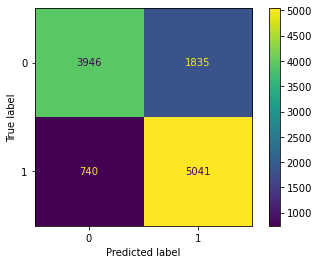

In [210]:
# Plot confusion matrix
plot_confusion_matrix(rf_model2,X_test_sm,y_test_sm)

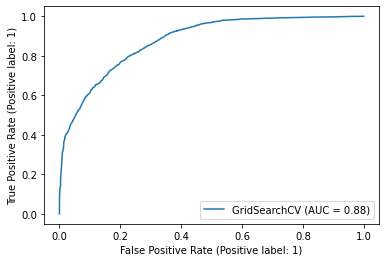

In [211]:
# plot the ROC Curve
plot_roc_curve(rfCV, X_test_sm, y_test_sm)

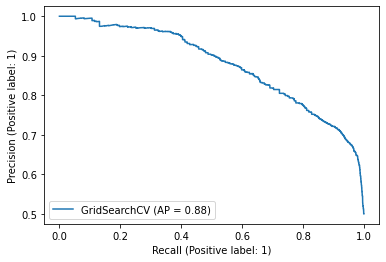

In [212]:
# Plot the precision-recall curve
plot_precision_recall_curve(rfCV, X_test_sm, y_test_sm)

In [213]:
print(classification_report(y_test_sm, rfCV.predict(X_test_sm),
                           target_names=["No","Yes"]))

              precision    recall  f1-score   support

          No       0.84      0.68      0.75      5781
         Yes       0.73      0.87      0.80      5781

    accuracy                           0.78     11562
   macro avg       0.79      0.78      0.78     11562
weighted avg       0.79      0.78      0.78     11562



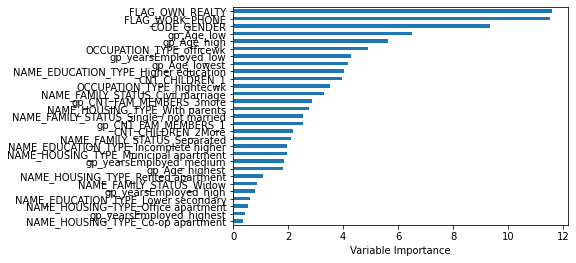

In [214]:
# Now, put them in DataFrame and plot them in a nice bar chart
impDf = pd.DataFrame({'Importance':rfCV.best_estimator_.feature_importances_*100}, index = X.columns)
impDf.sort_values('Importance', axis=0, ascending = True).plot(kind = 'barh')
plt.xlabel("Variable Importance")
plt.gca().legend_ = None

In [215]:
impDf.to_csv("FeatureImportance.csv",encoding='utf-8')

In [216]:
## Create a Metrics dataframe for the model
dfRFCV_sm = pd.DataFrame(modelMetrics(rfCV,"Random_Forest_CV",X_test_sm, y_test_sm))
dfRFCV_sm.transpose()

,a_score,accDefaulters,accNondefaulters,avg_p_score,errorDefaulters,errorNondefaulters,f1_score,falseNegative,falsePositive,p_score,r_score,roc_auc_score,trueNegative,truePositive
Random_Forest_CV,0.777288,0.871994,0.682581,0.877264,0.128006,0.317419,0.796555,740.0,1835.0,0.73313,0.871994,0.87818,3946.0,5041.0


In [217]:
dfRFCV_sm.transpose().to_csv("Team_5_RandomForest_Metrics.csv",encoding='utf-8')